In [1242]:
import sys
print(sys.version)

3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [1264]:
"""
Created on September 10 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)    

In [1265]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [1266]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1444]:
%load_ext autoreload
%autoreload 2

import Zernike_Module
from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1336]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  b

### 'unit test'

In [1220]:
sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))

allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.02,0.5,
                                 0.5,2,
                                 -0.0,0.00,
                                 0.99,0.0,1,
                                 50000,50,2.5,10**-1.2,
                                 0.47,1.85,1.0])

model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal)
print(res)
assert res<-6130 and res>-6140
print('ok')

-5795.83399854


AssertionError: 

### custom code 

In [1488]:
#specify number of observation which you want to analyze
obs='8603'
#specify single number which specifies which spot you want to anallyze - values are from 0 to 100, '55' is in the center of the detector 
single_number='55'
#load scientific and variance image
#sci_image =np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
#var_image =np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')

image_index=55
if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')


#obs_int=int(obs)
#obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
#z4Input_possibilites=np.array([28,24.5,21,17.5,14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14,-17.5,-21,-24.5,-28])
#z4Input=z4Input_possibilites[obs_possibilites==obs_int][0]

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent',
          'x_ilum','y_ilum','minorAxis','pupilAngle',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux'] 
"""
@param z4                     defocus parameter - if you give the observations number it will automaticly adjust but you can also pass the value manually below
@param z5-z11                 Zernike coefficents, following Noel convention

# pupil parameters
@param hscFracInit               Value determined how much of the exit pupil obscured by the central obscuration(detector) 
@param strutFracInit             Value determining how much of the exit pupil is obscured by a single strut
@param focalPlanePositionInit    2-tuple for position of the central obscuration(detector) in the focal plane
@param slitFracInit              Value determining how much of the exit pupil is obscured by slit
@param slitFrac_dy_Init          Value determining what is the vertical position of the slit in the exit pupil

#non-uniform illumination
@param radiometricEffectInit     parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param radiometricExponentInit   parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param x_ilumInit                x-position of the center of illumination of the exit pupil
@param y_ilumInit                y-position of the center of illumination of the exit pupil

# further pupil parameters
@param minorAxisInit             which fraction of major axis is the minor axis the ellipsoid describing the illumination of the exit pupil
@param pupilAngleInit            angle of the ellipsoid describing the illumination of the exit pupil
@param effective_ilum_radiusInit fraction of the maximal radius of the illumination of the exit pupil   
@param frd_sigma                 sigma of Gaussian convolving only outer edge, mimicking FRD
@param det_vert                  multiplicative factor determining vertical size of the detector obscuration
@param slitHolder_frac_dx        dx position of slit holder

# convolving parameters
@param grating_lines             number of effective lines in the grating
@param scattering_radiusInit     minimal radius to which extended the scattering [in units of microns] 
@param scattering_slopeInit      slope of scattering
@param scattering_amplitudeInit  amplitude of scattering compared to optical PSF
@param pixel_effectInit          sigma describing charge diffusion effect [in units of 15 microns]
@param fiber_rInit               radius of perfect tophat fiber, as seen on the detector [in units of 15 microns]         
@param fluxInit                  total flux in generated image compared to input image (probably 1 or close to 1)
"""

allparameters_proposal=np.array([    -0.08987438 ,     0.29065567  ,    0.57509303  ,   -1.1073552,  -0.21355587  ,   -0.32886583    ,  0.07912414    , -0.03618852,
      0.868281   ,    0.09993748   ,   0.0823797    ,  -0.00710934,  0.09049418  , -0.17724583  , 
     .2       ,       4.832551,   0.0116867  ,     0.22405513  , 
    0.99999195  ,    0.6555352, 0.9, 0.005,1.00,0.0,
 106886.664      ,   20.4317    ,      2.4772685 ,      0.01608282,   0.3870694  ,     1.8852437   ,    0.96219   ])

if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)  
    #model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,pupil_parameters=[0.65,0.1,0.,0.,0.08,0,0.99,0.0,1,0.04,1,0])   

modelP =LNP_PFS(sci_image,var_image)


model(allparameters_proposal)

[     -0.08987438       0.29065567       0.57509303      -1.1073552
      -0.21355587      -0.32886583       0.07912414      -0.03618852
       0.868281         0.09993748       0.0823797       -0.00710934
       0.09049418      -0.17724583       0.2              4.832551
       0.0116867        0.22405513       0.99999195       0.6555352
       0.9              0.005            1.               0.          106886.664
      20.4317           2.4772685        0.01608282       0.3870694
       1.8852437        0.96219   ]


-21358.813817653092

In [1512]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    #model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)  
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,pupil_parameters=np.array([ 0.65952266,  0.16735511 ,-0.02852821 , 0.09037884,  0.01630378,  0.08753993,
                                                                                    0.99295579, -0.07941925 , 0.71549089 , 0.05811413  ,0.98410936, -0.00104982])  ) 

modelP =LNP_PFS(sci_image,var_image)


model(allparameters_proposal)

-3619.9260841236292

In [1513]:
allparameters_proposal=np.array([z4Input,0.00,0.00,-0.0,0.0,0.0,0.00,0.0,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.7,2,-0.2,0.00,
                                 0.99,0.0,1,
                                 0.04,1,0,
                                 50000,50,2.5,10**-1.2,
                                 0.47,1.85,1.0]) 
allparameters_proposal

array([     0.        ,      0.        ,      0.        ,     -0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.65      ,      0.1       ,      0.        ,      0.        ,
            0.08      ,      0.        ,      0.7       ,      2.        ,
           -0.2       ,      0.        ,      0.99      ,      0.        ,
            1.        ,      0.04      ,      1.        ,      0.        ,
        50000.        ,     50.        ,      2.5       ,      0.06309573,
            0.47      ,      1.85      ,      1.        ])

In [1504]:
allparameters_proposal==add_pupil_parameters_to_all_parameters(allparameters_proposal_short,pupil_parameters)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

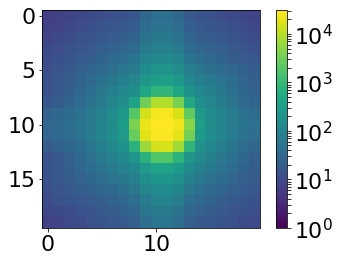

In [1514]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

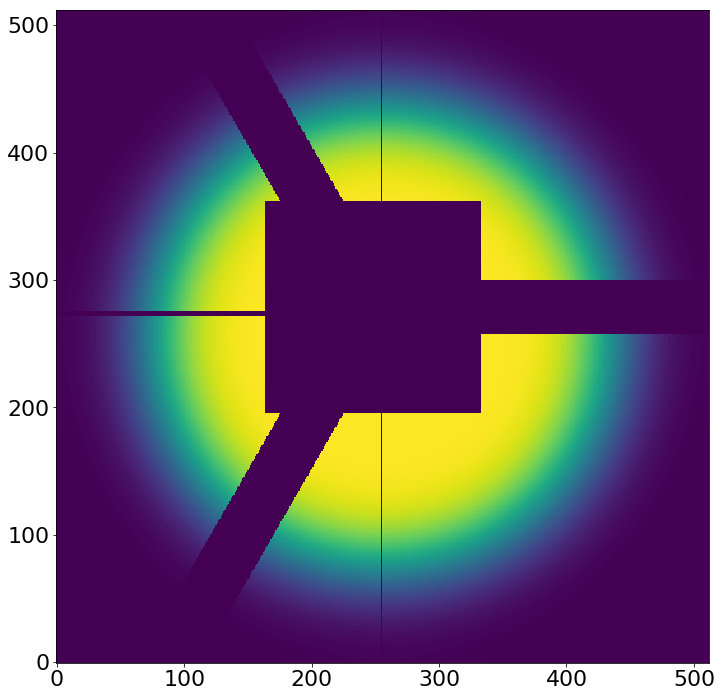

In [1515]:
plt.figure(figsize=(12,12))
plt.imshow(pupililluminated,origin='lower')

In [1386]:
allparameters_proposal

array([     -0.08987438,       0.29065567,       0.57509303,
            -1.1073552 ,      -0.21355587,      -0.32886583,
             0.07912414,      -0.03618852,       0.868281  ,
             0.09993748,       0.0823797 ,      -0.00710934,
             0.09049418,      -0.17724583,       0.2       ,
             4.832551  ,       0.0116867 ,       0.22405513,
             0.99999195,       0.6555352 ,       0.9       ,
             0.005     ,       1.        ,       0.        ,
        106886.664     ,      20.4317    ,       2.4772685 ,
             0.01608282,       0.3870694 ,       1.8852437 ,       0.96219   ])

In [1467]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,pupil_parameters=[0.868,0.099,0.09,-0.177,0.05,0.5,1,0.99,0.99,0.05,1,0])
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,pupil_parameters=[0.868,0.099,0.09,-0.177,0.05,0.5,1,0.99,0.99,0.06,1,0])   

model(remove_pupil_parameters_from_all_parameters(allparameters_proposal))

OrderedDict([('z4', -0.089874380000000004), ('z5', 0.29065566999999998), ('z6', 0.57509303000000001), ('z7', -1.1073552), ('z8', -0.21355587000000001), ('z9', -0.32886583000000003), ('z10', 0.079124139999999996), ('z11', -0.036188520000000002), ('dx', 0.0), ('dy', 0.0), ('hscFrac', 0.86799999999999999), ('strutFrac', 0.099000000000000005), ('dxFocal', 0.089999999999999997), ('dyFocal', -0.17699999999999999), ('slitFrac', 0.050000000000000003), ('slitFrac_dy', 0.5), ('fiber_r', 1.8852437), ('radiometricEffect', 0.20000000000000001), ('trace_value', 0), ('serial_trace_value', 0), ('pixel_effect', 0.38706940000000001), ('background', 0), ('flux', 0.96218999999999999), ('x_ilum', 0.0116867), ('y_ilum', 0.22405512999999999), ('radiometricExponent', 4.8325509999999996), ('minorAxis', 1.0), ('effective_ilum_radius', 0.98999999999999999), ('pupilAngle', 0.98999999999999999), ('grating_lines', 106886.664), ('scattering_radius', 20.431699999999999), ('scattering_slope', 2.4772685000000001), ('sc

-20968.055123075646

In [1446]:
remove_pupil_parameters_from_all_parameters(allparameters_proposal)



array([     -0.08987438,       0.29065567,       0.57509303,
            -1.1073552 ,      -0.21355587,      -0.32886583,
             0.07912414,      -0.03618852,       0.2       ,
             4.832551  ,       1.        ,       0.        ,
        106886.664     ,      20.4317    ,       2.4772685 ,
             0.01608282,       0.3870694 ,       1.8852437 ,       0.96219   ])

In [1452]:
test_par=remove_pupil_parameters_from_all_parameters(allparameters_proposal)
test_par

array([     -0.08987438,       0.29065567,       0.57509303,
            -1.1073552 ,      -0.21355587,      -0.32886583,
             0.07912414,      -0.03618852,       0.2       ,
             4.832551  ,       1.        ,       0.        ,
        106886.664     ,      20.4317    ,       2.4772685 ,
             0.01608282,       0.3870694 ,       1.8852437 ,       0.96219   ])

In [1465]:
def add_pupil_parameters_to_all_parameters(parameters,pupil_parameters):
    lenpar=len(parameters)
    return np.concatenate((parameters[:lenpar-11],pupil_parameters[:6],parameters[lenpar-11:lenpar-7],pupil_parameters[6:],parameters[lenpar-7:]),axis=0)

In [1464]:
pupil_parameters=[0.868,0.099,0.09,-0.177,0.05,0.5,1,0.99,0.99,0.05,1,0]
add_pupil_parameters_to_all_parameters(test_par,pupil_parameters)

array([     -0.08987438,       0.29065567,       0.57509303,
            -1.1073552 ,      -0.21355587,      -0.32886583,
             0.07912414,      -0.03618852,       0.868     ,
             0.099     ,       0.09      ,      -0.177     ,
             0.05      ,       0.5       ,       0.2       ,
             4.832551  ,       1.        ,       0.99      ,
             0.99      ,       0.05      ,       1.        ,
             0.        ,       1.        ,       0.        ,
        106886.664     ,      20.4317    ,       2.4772685 ,
             0.01608282,       0.3870694 ,       1.8852437 ,       0.96219   ])

In [1460]:
test_par[:len(test_par)-11]

array([-0.08987438,  0.29065567,  0.57509303, -1.1073552 , -0.21355587,
       -0.32886583,  0.07912414, -0.03618852])

In [1425]:
from functools import lru_cache
@lru_cache(maxsize=3200)
def test(test_par):
    return np.sum(test_par)

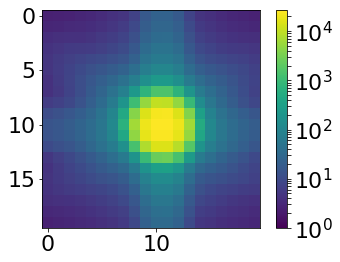

In [1404]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

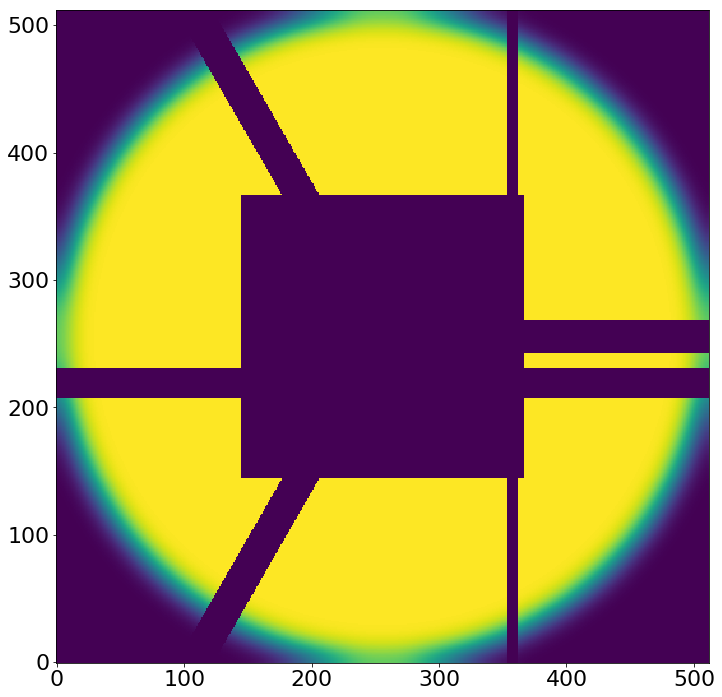

In [1405]:
plt.figure(figsize=(12,12))
plt.imshow(pupililluminated,origin='lower')

In [777]:
obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
z4Input_possibilites=np.array([28,24.5,21,17.5,14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14,-17.5,-21,-24.5,-28])
defocus_possibilites=np.array([-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0,0.5,1,1.5,2,2.5,3,3.5,4])

allparameters_proposal=np.array([-7,0.00,0.00,-0.0,0.0,0.0,0.00,0.0,0,0.00,0.00,-0.0,0.0,0.0,0.00,0.0,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.7,2,
                                 -0.2,0.00,
                                 0.99,0.0,1,
                                 50000,50,2.5,10**-1.2,
                                 0.47,1.85,1.0]) 

nT=2
parInit1=create_parInit(allparameters_proposal,multi=1)
parInit2=create_parInit(allparameters_proposal,multi=1)
parInitnT=np.array([parInit1,parInit2])

In [801]:
obs_int_array=[8567,8603,8606]
sci_image_array=[]
var_image_array=[]
for obs in obs_int_array:
    if obs=='8600':
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
    else:
        sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
        var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')
        
    sci_image_array.append(sci_image)
    var_image_array.append(var_image)

for i in range(len(obs_int_array)):
    globals()['model'+str(i)] = LN_PFS_single(sci_image_array[i],var_image_array[i],dithering=1,save=1)

In [802]:
sorter = np.argsort(obs_possibilites)
defocus_array=defocus_possibilites[sorter[np.searchsorted(obs_possibilites, obs_int_array, sorter=sorter)]]

In [799]:
def multi_model(parameters):
        
    res=[]
    for i in range(len(obs_int_array)):
        parameters_single=create_x(defocus_array[i],parameters)
        print(parameters_single)
        res.append(globals()['model'+str(i)](parameters_single))
    print(res)
    return np.sum(res)
    

In [803]:
multi_model(allparameters_proposal2)

[     7.2            -0.              0.              0.              0.
     -0.              0.              0.              0.65            0.1
      0.              0.              0.08            0.              0.7
      2.             -0.2             0.              0.99            0.
      1.          50000.             50.              2.5             0.06309573
      0.47            1.85            1.        ]
[     0.              0.              0.              0.              0.
      0.              0.              0.              0.65            0.1
      0.              0.              0.08            0.              0.7
      2.             -0.2             0.              0.99            0.
      1.          50000.             50.              2.5             0.06309573
      0.47            1.85            1.        ]
[    -2.4             0.              0.              0.              0.
      0.              0.              0.              0.65            0.1
   

-2603911.0521860463

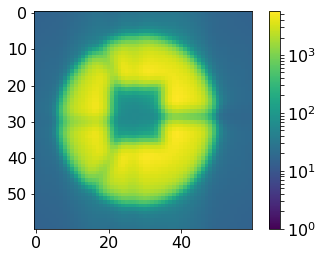

In [1195]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

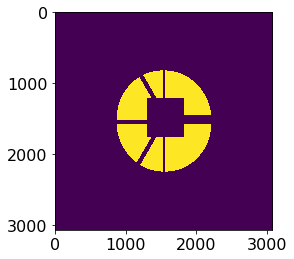

In [1197]:
plt.imshow(ilum)

In [59]:
airy = galsim.Airy(diam=0.138, lam=500)
stepk = airy.stepk

In [60]:
stepk

0.10372264323065072

In [63]:
good_pupil_scale = (stepk * 500 * 1.e-9 * (galsim.radians / galsim.arcsec)
                    / (2 * np.pi * 1))
good_pupil_scale

0.001702506759187914

In [38]:
import inspect

In [40]:
source_DF = inspect.getsource(galsim.Aperture)

In [41]:
print(source_DF)

class Aperture(object):
    """ Class representing a telescope aperture embedded in a larger pupil plane array -- for use
    with the PhaseScreenPSF class to create PSFs via Fourier or geometric optics.

    The pupil plane array is completely specified by its size, sampling interval, and pattern of
    illuminated pixels.  Pupil plane arrays can be specified either geometrically or using an image
    to indicate the illuminated pixels.  In both cases, various options exist to control the pupil
    plane size and sampling interval.

    Geometric pupil specification
    -----------------------------

    The first way to specify the details of the telescope aperture is through a series of keywords
    indicating the diameter, size of the central obscuration, and the nature of the struts
    holding up the secondary mirror (or prime focus cage, etc.).  The struts are assumed to be
    rectangular obscurations extending from the outer edge of the pupil to the outer edge of the
    obscu

# Analysis 

## Scripts

In [1520]:
for single_spot in [35,45,55,75,85,95]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8552, 8564, 8603, 8615, 8627]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close() 
    
for single_spot in [35,45,55,75,85,95]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(2)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555, 8567, 8606, 8618]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()     
    
for single_spot in [35,45,55,75,85,95]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(3)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8558, 8570, 8609, 8621]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()     
  
for single_spot in [35,45,55,75,85,95]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(4)+'S'+str(single_spot)+'Sep_P.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8561, 8573, 8612, 8624]:
        file.write("python /home/ncaplar/Code/ZernikeSingle_Sep.py "+str(obs)+" "+str(single_spot)+" 150 1\n")
    file.close()    
    
for single_spot in [5,25,35,45,55,75,85,95,56,57,58,59,54,52,51,50]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(single_spot)+'Sep_P_Multi.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    file.write("python /home/ncaplar/Code/ZernikeMulti_Sep.py "+'8552,8561,8573,8603,8606,8618,8627'+" "+str(single_spot)+" 160 1\n")
    file.close()    

In [1521]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SeptemberScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for obs in [1]:
    for single_spot in [5,25,35,45,55,75,85,95,56,57,58,59,54,52,51,50]:
        file.write('sbatch /home/ncaplar/Scripts/T'+str(1)+'S'+str(single_spot)+'Sep_P_Multi.sh \n')

        
file.close()

## Core Analysis (pandas dataframe creation)

In [872]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
        'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
        'radiometricEffect','radiometricExponent',
        'x_ilum','y_ilum',
        'minorAxis','pupilAngle','effective_radius_illumination',
        'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
        'pixel_effect','fiber_r','flux']         

columns_analysis=columns+['chi2','chi2max']

results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

In [873]:
results_of_fit_single

z4   z5   z6   z7   z8   z9  z10  z11  hscFrac  strutFrac   ...     \
-4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
-3.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
-3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
-2.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
-2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
-1.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
-1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
-0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
0.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
1.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
2.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
3.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0   ...      

      effective_radius_illumination  grating_lines  scattering_radius  \
-4.0                            0.0            0.0                0.0   
-3.5                            0.0            0.0                0.0   
-3.0                            0.0            0.0                0.0   
-2.5                            0.0            0.0                0.0   
-2                              0.0            0.0                0.0   
-1.5                            0.0            0.0                0.0   
-1                              0.0            0.0                0.0   
-0.5                            0.0            0.0                0.0   
0                               0.0            0.0                0.0   
0                               0.0            0.0                0.0   
0.5                             0.0            0.0                0.0   
1                               0.0            0.0                0.0   
1.5                             0.0            0.0                0.0   
2                               0.0            0.0                0.0   
2.5                             0.0            0.0                0.0   
3.0                             0.0            0.0                0.0   
3.5                             0.0            0.0                0.0   
4                               0.0            0.0                0.0   

      scattering_slope  scattering_amplitude  pixel_effect  fiber_r  flux  \
-4.0               0.0                   0.0           0.0      0.0   0.0   
-3.5               0.0                   0.0           0.0      0.0   0.0   
-3.0               0.0                   0.0           0.0      0.0   0.0   
-2.5               0.0                   0.0           0.0      0.0   0.0   
-2                 0.0                   0.0           0.0      0.0   0.0   
-1.5               0.0                   0.0           0.0      0.0   0.0   
-1                 0.0                   0.0           0.0      0.0   0.0   
-0.5               0.0                   0.0           0.0      0.0   0.0   
0                  0.0                   0.0           0.0      0.0   0.0   
0                  0.0                   0.0           0.0      0.0   0.0   
0.5                0.0                   0.0           0.0      0.0   0.0   
1                  0.0                   0.0           0.0      0.0   0.0   
1.5                0.0                   0.0           0.0      0.0   0.0   
2                  0.0                   0.0           0.0      0.0   0.0   


In [874]:
# arrange all results in one pandas 
date='Sep13'

RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8600,8603,8606,8609,8612,8615,8618,8621,8624,8627]

single_number=35
image_index=single_number
method='P'
eps=1

res_likelihood=[]

for single_defocus in tqdm(range(0,len(single_defocus_list))):
    try:
        obs=single_defocus_list[single_defocus]
        try:

            chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
            likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
            print('obs (Emcee3): '+str(obs)+' is found!')
        except:    
            chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
            likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
            
        
        if obs==8600:
            sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
            var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
        else:       
            sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
            var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

        likechain0=likechain[0]

        chain0=chain[0]
        minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
        chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2


        
        minchain_err=[]
        for i in range(len(columns)):
            #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
            minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

        minchain_err=np.array(minchain_err)
        results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
        err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err,np.array([1,1])),axis=0)
        


    except:
        ValueError

 17%|█████████▋                                                | 3/18 [00:00<00:00, 29.00it/s]

obs (Emcee3): 8552 is found!
obs (Emcee3): 8558 is found!
obs (Emcee3): 8561 is found!
obs (Emcee3): 8564 is found!


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 43.04it/s]

obs (Emcee3): 8570 is found!
obs (Emcee3): 8573 is found!
obs (Emcee3): 8603 is found!
obs (Emcee3): 8615 is found!


In [875]:
results_of_fit_single_full=np.copy(results_of_fit_single)
err_results_of_fit_single_full=np.copy(err_results_of_fit_single)

results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]

results_of_fit_single_without_focus=results_of_fit_single.copy()
err_results_of_fit_single_without_focus=err_results_of_fit_single.copy()
results_of_fit_single_without_focus=results_of_fit_single_without_focus[results_of_fit_single_without_focus.index.values!='0']
err_results_of_fit_single_without_focus=err_results_of_fit_single_without_focus[err_results_of_fit_single_without_focus.index.values!='0']

results_of_fit_single_only_focus=results_of_fit_single.copy()
err_results_of_fit_single_only_focus=err_results_of_fit_single.copy()
results_of_fit_single_only_focus=results_of_fit_single_only_focus[results_of_fit_single_only_focus.index.values=='0']
err_results_of_fit_single_only_focus=err_results_of_fit_single[err_results_of_fit_single_only_focus.index.values=='0']

results_of_fit_single

z4        z5        z6        z7        z8        z9       z10  \
-4.0  27.632515 -0.454004 -0.503731  0.073859  0.505499 -0.041816 -0.199798   
-3.5  28.065757 -0.020444 -0.432642  0.558894  0.111971  0.025003 -0.344577   
-3.0  19.624997 -0.194153 -0.272256  0.371986  0.163845 -0.055353 -0.193150   
-2.5  25.009138 -0.319227 -1.276165  0.421935  0.011559 -0.113334 -0.325424   
-2    13.074349 -0.259579 -0.279417  0.343088  0.229841 -0.090180 -0.198267   
-1     6.435818 -0.278766 -0.434281  0.405666  0.023880 -0.139158 -0.256299   
-0.5   3.203905 -0.035054 -0.317104  0.148088  0.047604 -0.125238 -0.166376   
0      1.203134  0.482928  0.024266  0.081173  0.090338 -0.301297 -0.242395   
1    -11.433247 -0.143242  0.051041  0.263151 -0.296899 -0.383327 -0.228690   
2    -14.630345 -0.200738  0.171722  0.257363 -0.345130 -0.175846 -0.349780   

           z11   hscFrac  strutFrac     ...       \
-4.0 -0.338049  0.683110   0.078197     ...        
-3.5  0.604440  0.910736   0.114524     ...        
-3.0 -0.333983  0.701588   0.084586     ...        
-2.5 -0.179611  0.828159   0.098364     ...        
-2   -0.152854  0.716508   0.082914     ...        
-1   -0.413957  0.605119   0.085959     ...        
-0.5 -0.154278  0.661881   0.110748     ...        
0     0.233221  0.688736   0.076628     ...        
1    -0.371060  0.744096   0.088330     ...        
2    -0.191733  0.666065   0.085999     ...        

      effective_radius_illumination  grating_lines  scattering_radius  \
-4.0                       0.906786   23025.287361         598.347376   
-3.5                       1.001080   34243.438207         688.067418   
-3.0                       0.964734   31578.034929          55.193529   
-2.5                       0.980571   32026.540052         202.204900   
-2                         0.898964   64833.229598          82.319345   
-1                         0.853847   14781.295408         269.948317   
-0.5                       0.859798   14585.389479         313.373571   
0                          0.628835   16360.237996         428.771916   
1                          0.974246   59243.026159          44.759725   
2                          0.977227   77239.921368          70.209141   

      scattering_slope  scattering_amplitude  pixel_effect   fiber_r  \
-4.0          2.390631              0.040633      0.526799  2.177161   
-3.5          1.727814              0.057953      0.665296  2.106485   
-3.0          3.182072              0.060357      0.424088  1.934229   
-2.5          1.902201              0.033300      0.821318  1.911506   
-2            2.431388              0.025440      0.630652  1.680539   
-1            2.509834              0.019953      0.257219  1.832235   
-0.5          2.023207              0.027728      0.336237  1.696509   
0             1.403198              0.013512      0.404712  1.720350   
1             2.833851              0.118185      0.793358  1.982647   
2             2.620317              0.078506      0.541226  1.855377   

          flux       chi2      chi2max  
-4.0  0.995980  14.871954  1120.675659  
-3.5  0.960335  22.632768  1168.473633  
-3.0  1.000850  11.763636  1492.423340  
-2.5  1.008906   7.070475  1709.241089  
-2    0.996356   7.028325  1404.700562  
-1    0.994687   4.000533  1327.776611  
-0.5  0.998397   1.609334   854.754211  
0     1.001183   2.499022   860.227173  
1     0.960693   4.980419   532.656921  
2     0.992997   4.180961   827.287964  

[10 rows x 30 columns]

In [876]:
index_arr=np.array(err_results_of_fit_single.index).astype(float)

q='z8'
z4_arr=np.array(results_of_fit_single[q])
z4_arr_err=np.array(err_results_of_fit_single[q])
popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)

In [877]:
fit_res=[]
for i in np.linspace(-4.5,4.5,19):
    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))

In [926]:
IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

solution_at_0=[]
for q in columns_analysis:
    z4_arr=np.array(results_of_fit_single[q])
    z4_arr_err=np.array(err_results_of_fit_single[q])
    
    z4_arr_no0=np.array(results_of_fit_single_without_focus[q])
    z4_arr_no0_err=np.array(err_results_of_fit_single_without_focus[q])
    
    z4_arr_only0=np.array(results_of_fit_single_only_focus[q])
    z4_arr_only0_err=np.array(err_results_of_fit_single_only_focus[q])
  
    
    
    #popt, pcov = curve_fit(lin_fit_1D, index_arr, z4_arr, sigma=z4_arr_err)
    
    #index_arr=np.array(results_of_fit_single.index.values)
    #index_arr=np.array(map(float,index_arr))
    index_arr_plot=np.copy(index_arr)
    #index_arr_plot[5]=index_arr_plot[5]+0.01
    
    index_arr_no0=np.array(results_of_fit_single_without_focus.index).astype(float)

    if len(results_of_fit_single_only_focus.index)>10:
        index_arr_only0=np.array([0])
    else:
        index_arr_only0=np.array(results_of_fit_single_only_focus.index).astype(float)       
    

     
    
    fit_res=[]
    if q in columns[:8]:
        popt, pcov = curve_fit(lin_fit_1D, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
        for i in np.linspace(-4.5,4.5,19):
            fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
        solution_at_0.append(fit_res[9])
    if q in np.concatenate((np.array(columns[8:21]),np.array(['pixel_effect'])),axis=0):
        popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_no0, z4_arr_no0, sigma=z4_arr_no0_err)
        for i in np.linspace(-4.5,4.5,19):
            fit_res.append(lin_fit_1DConstant(i,popt[0]))
        solution_at_0.append(fit_res[9])
    if q in np.array(['grating_lines','scattering_radius', 'scattering_slope', 'scattering_amplitude','fiber_r','flux','chi2','chi2max']):
        if z4_arr_only0.size==1:
            for i in np.linspace(-4.5,4.5,19):
                fit_res.append(z4_arr_only0) 
            solution_at_0.append(fit_res[9])
        else:
            popt, pcov = curve_fit(lin_fit_1DConstant, index_arr_only0, z4_arr_only0, sigma=z4_arr_only0_err)
            for i in np.linspace(-4.5,4.5,19):
                fit_res.append(lin_fit_1DConstant(i,popt[0]))    
            solution_at_0.append(fit_res[9])
            

    #solution_at_0.append(fit_res[5])
    plt.figure(figsize=(20,10))
    plt.errorbar(index_arr_plot,z4_arr,yerr=z4_arr_err,color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
    plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
    plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),'--',color='black')
    plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red")
    plt.title(q,size=40)
    plt.legend(fontsize=25)
    plt.xlabel('defocus lab [mm]',size=30)
    plt.ylabel('defocus model',size=30)
    
    if not os.path.exists(IMAGES_FOLDER+'Defocus/'):
        os.makedirs(IMAGES_FOLDER+'Defocus/')
    plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q))
    plt.close()
    
solution_at_0=np.array(solution_at_0)

## Look at result of the analysis at one single point

In [1154]:
obs='8552'
single_number='35'
image_index=int(single_number)
eps=1
date='Sep13'

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

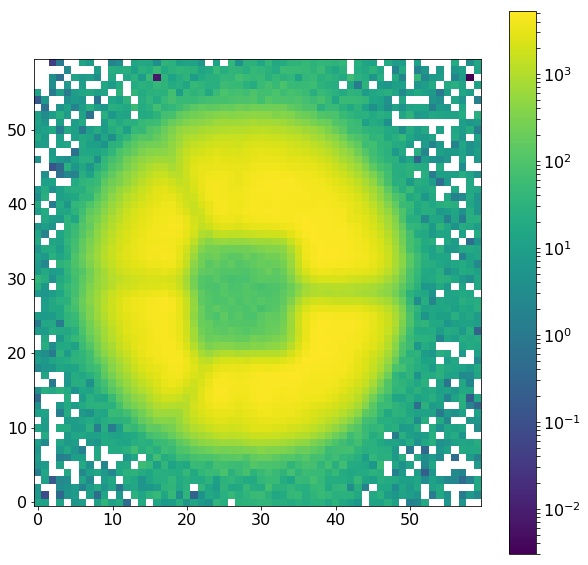

In [1155]:
plt.figure(figsize=(10,10))
plt.imshow(sci_image,norm=LogNorm(),origin='lower')
plt.colorbar()

In [1162]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps)
single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (224, 300, 28)
minimal likelihood is: 26769.5167878
minimal chi2 reduced is: 14.8672566854


In [1163]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])
print(dfglobal)

          z4        z5        z6        z7        z8        z9       z10  \
0  27.632515 -0.454004 -0.503731  0.073859  0.505499 -0.041816 -0.199798   

        z11  
0 -0.338049  
   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.68311   0.078197  0.022177 -0.065325  0.067757     0.016091   

   radiometricEffect  radiometricExponent   x_ilum    y_ilum  minorAxis  \
0            0.60069             2.457272  0.11657 -0.032806     0.9367   

   pupilAngle  effective_radius_illumination  grating_lines  \
0   -0.078684                       0.906786   23025.287361   

   scattering_radius  scattering_slope  scattering_amplitude  pixel_effect  \
0         598.347376          2.390631              0.040633      0.526799   

    fiber_r     flux  
0  2.177161  0.99598  


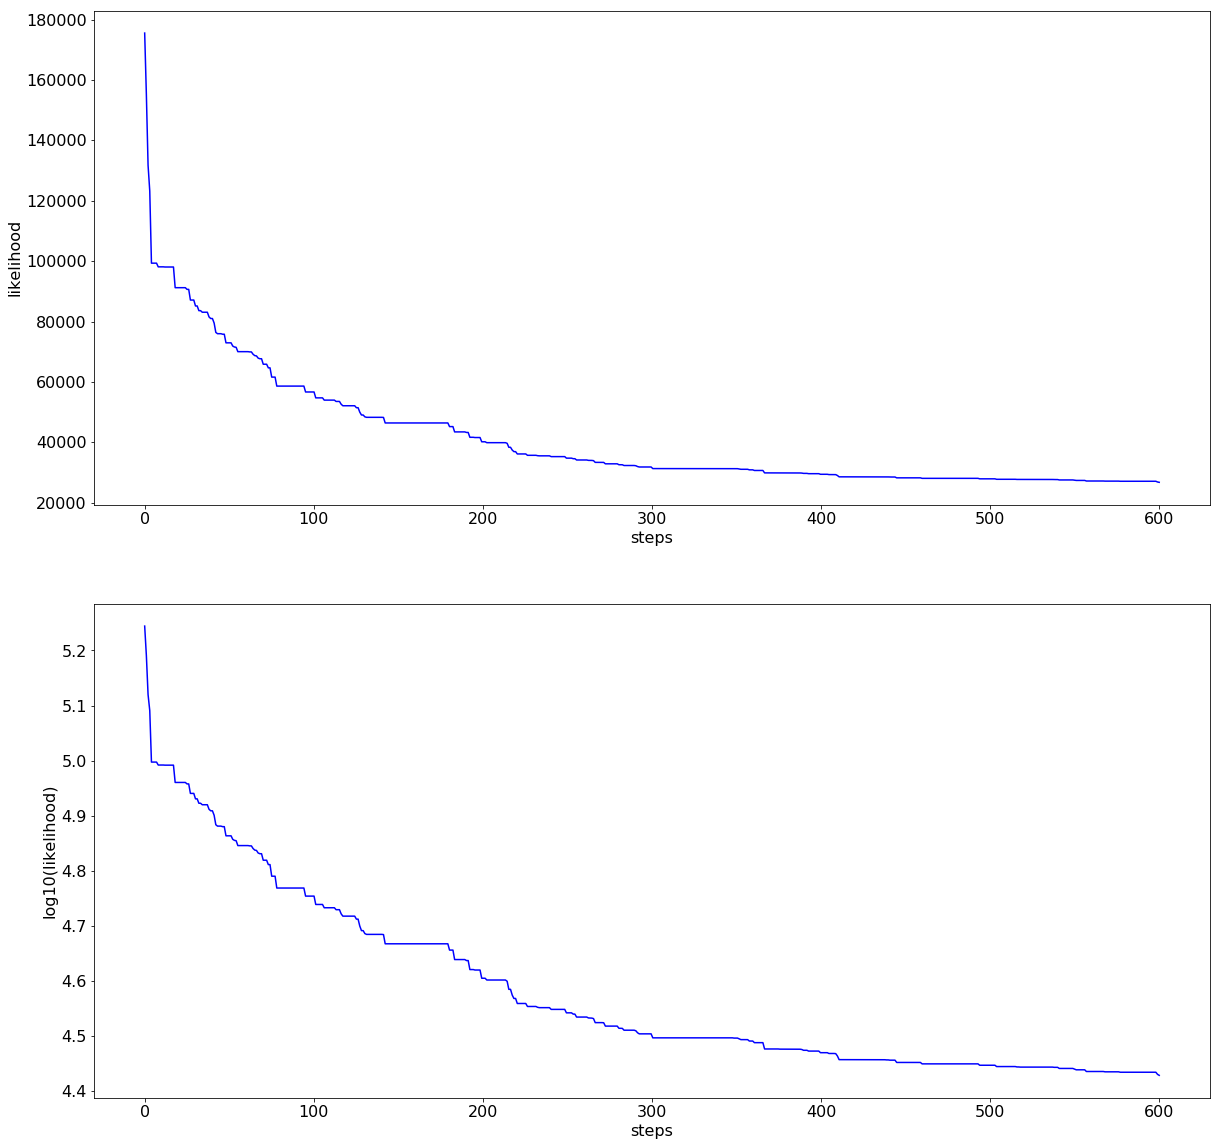

In [1164]:
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(0,len(like_min),len(like_min)),like_min,'blue',ls='-')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.subplot(212)
plt.plot(np.linspace(0,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')

In [1213]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   

model(minchain)


-6211343.7565547647

In [1214]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

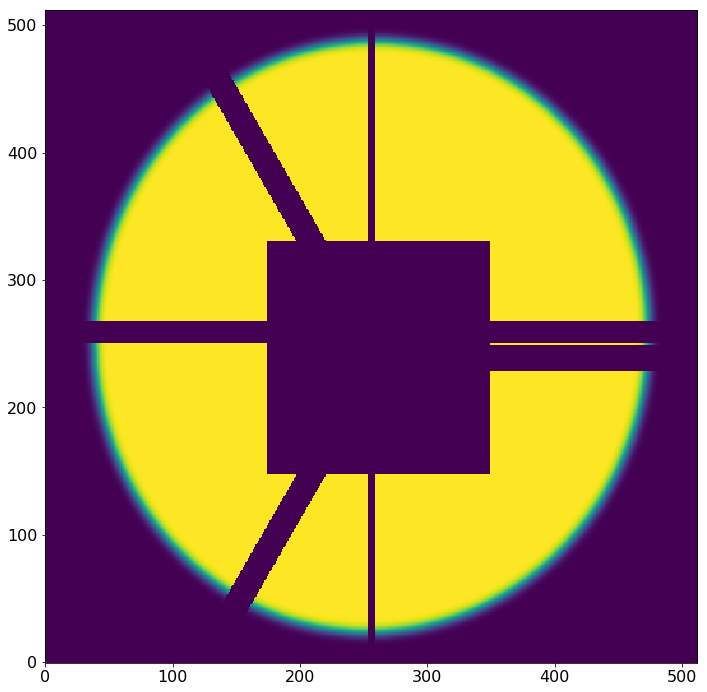

In [1215]:
plt.figure(figsize=(12,12))
plt.imshow(pupililluminated,origin='lower')

chi**2 reduced is: 21.0894211406
Abs of residual divided by total flux is: 0.10759412514
Abs of residual divided by largest value of a flux in the image is: 0.266640201816


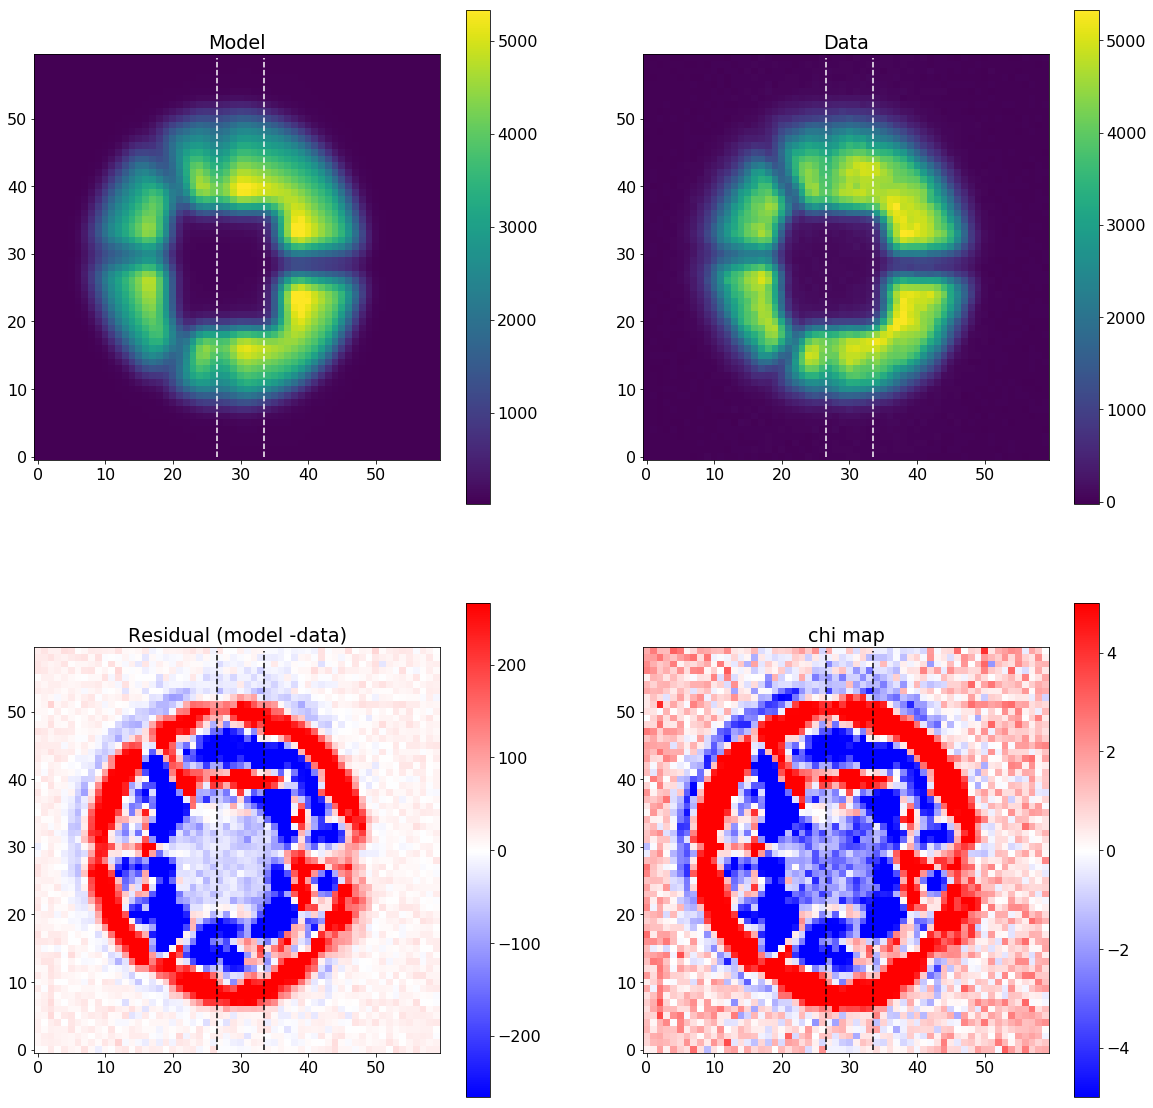

In [1170]:
single_analysis.create_basic_comparison_plot()

21.0894211406
chi**2 reduced is: 21.0894211406
Abs of residual divided by total flux is: 0.10759412514
Abs of residual divided by largest value of a flux in the image is: 0.266640201816


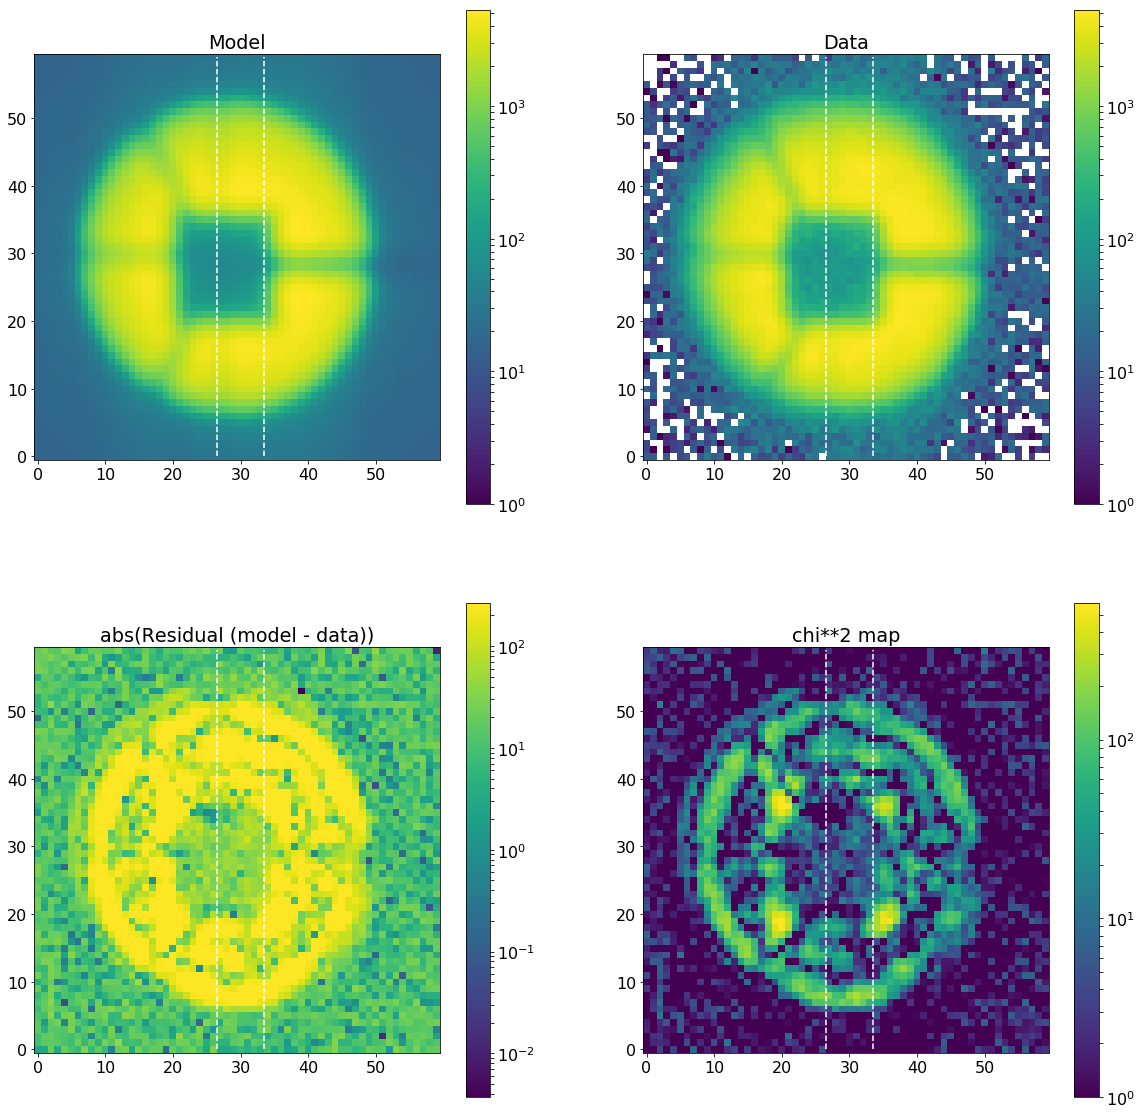

In [1171]:
single_analysis.create_basic_comparison_plot_log()

In [974]:
artifical_noise=single_analysis.create_artificial_noise()

16.6669771988


0.078674719031524343

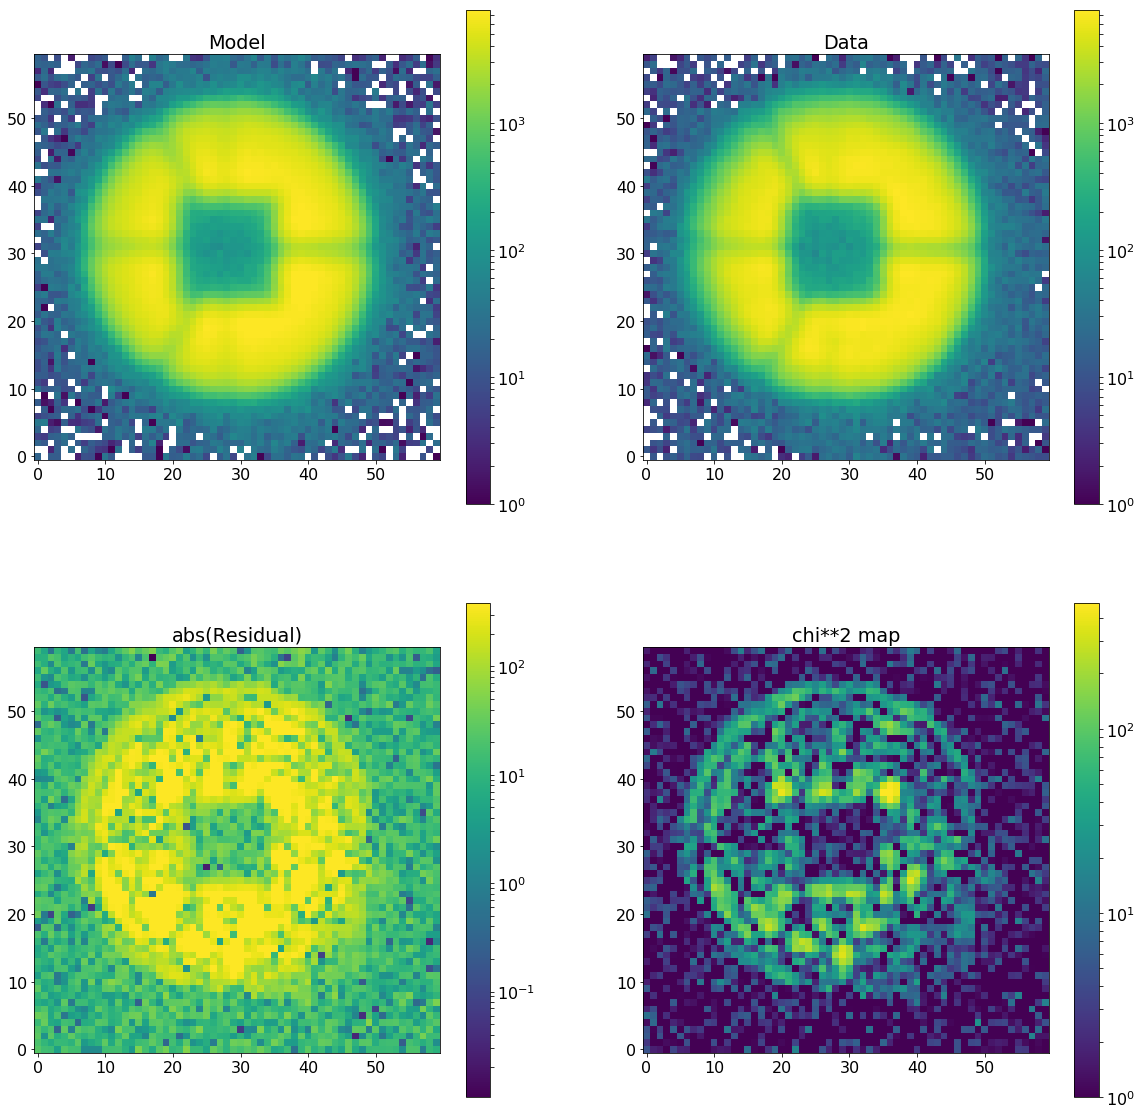

In [960]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

269.379970106
598.277957444


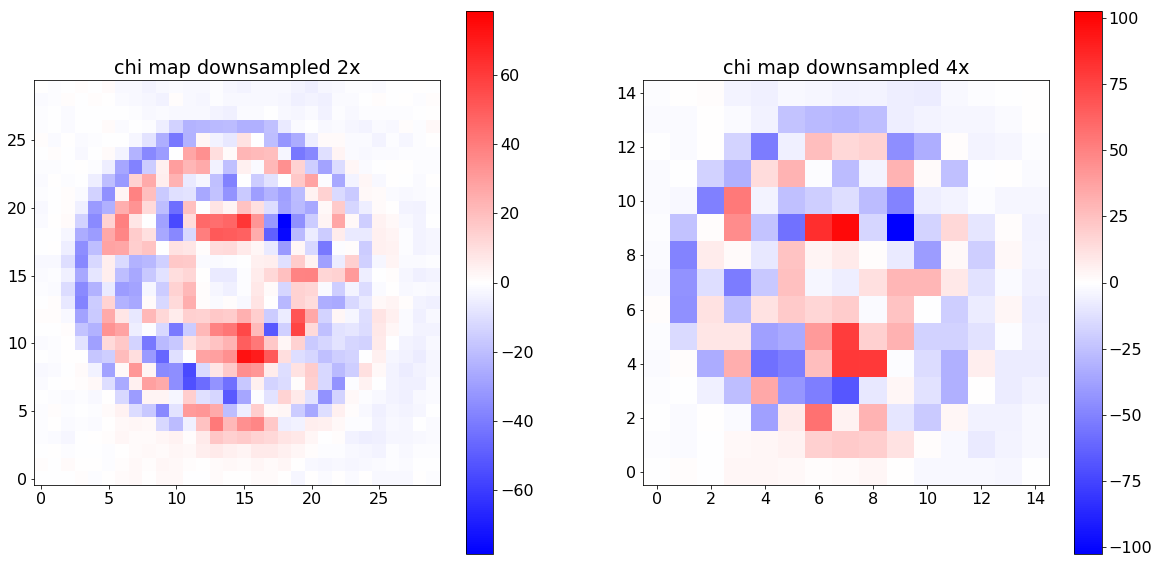

In [976]:
sci_image_2=downsample_manual_function(sci_image,int(sci_image.shape[0]/2))
sci_image_4=downsample_manual_function(sci_image,int(sci_image.shape[0]/4))

res_iapetus_2=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/2))
res_iapetus_4=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/4))

var_image_2=downsample_manual_function(var_image,int(var_image.shape[0]/2))
var_image_4=downsample_manual_function(var_image,int(var_image.shape[0]/4))

chi_downsample_2=(res_iapetus_2-sci_image_2)/np.sqrt(var_image_2)
chi_downsample_4=(res_iapetus_4-sci_image_4)/np.sqrt(var_image_4)

print(np.mean(chi_downsample_2**2))
print(np.mean(chi_downsample_4**2))


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_2,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_2)),vmax=np.max(np.abs(chi_downsample_2)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_4,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_4)),vmax=np.max(np.abs(chi_downsample_4)))
plt.colorbar()
plt.title('chi map downsampled 4x')

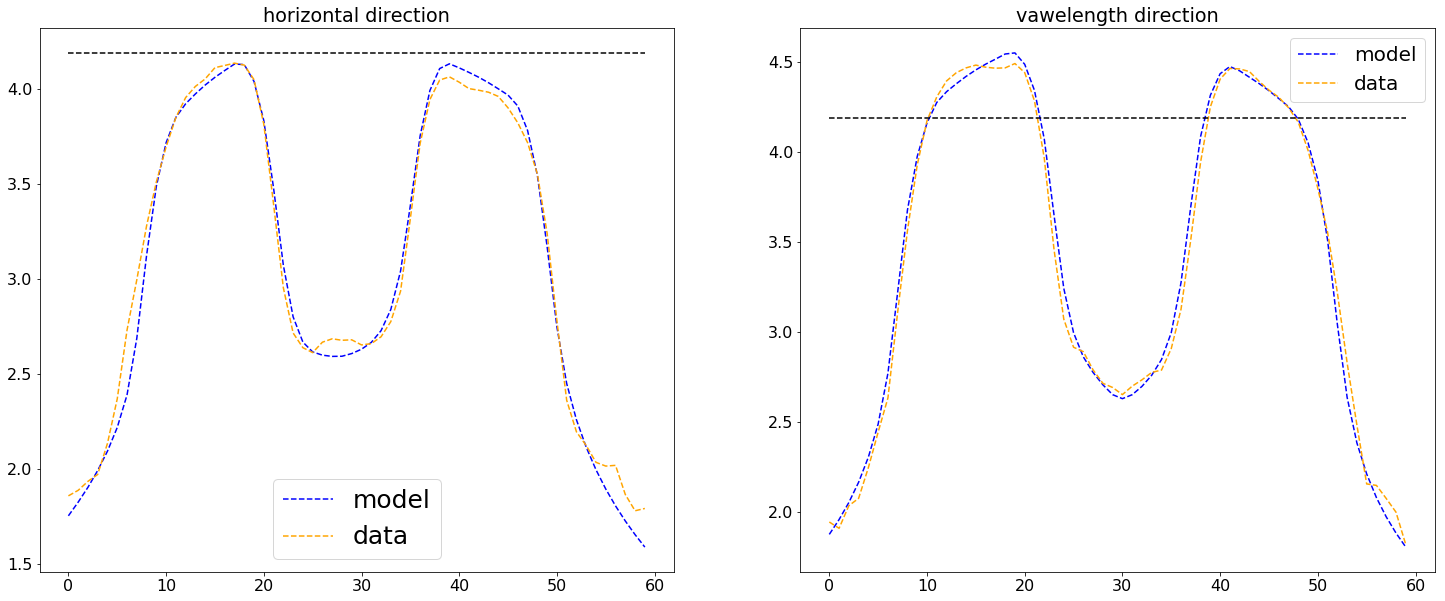

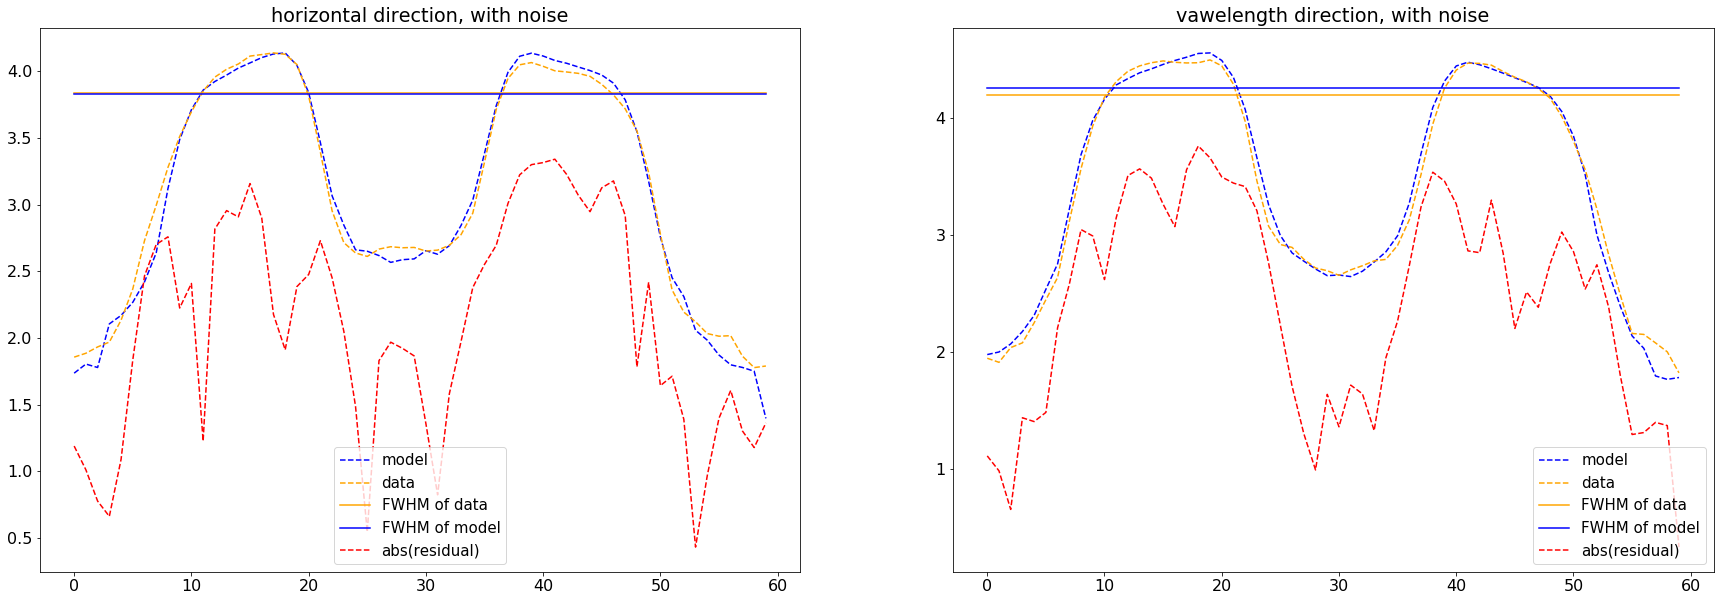

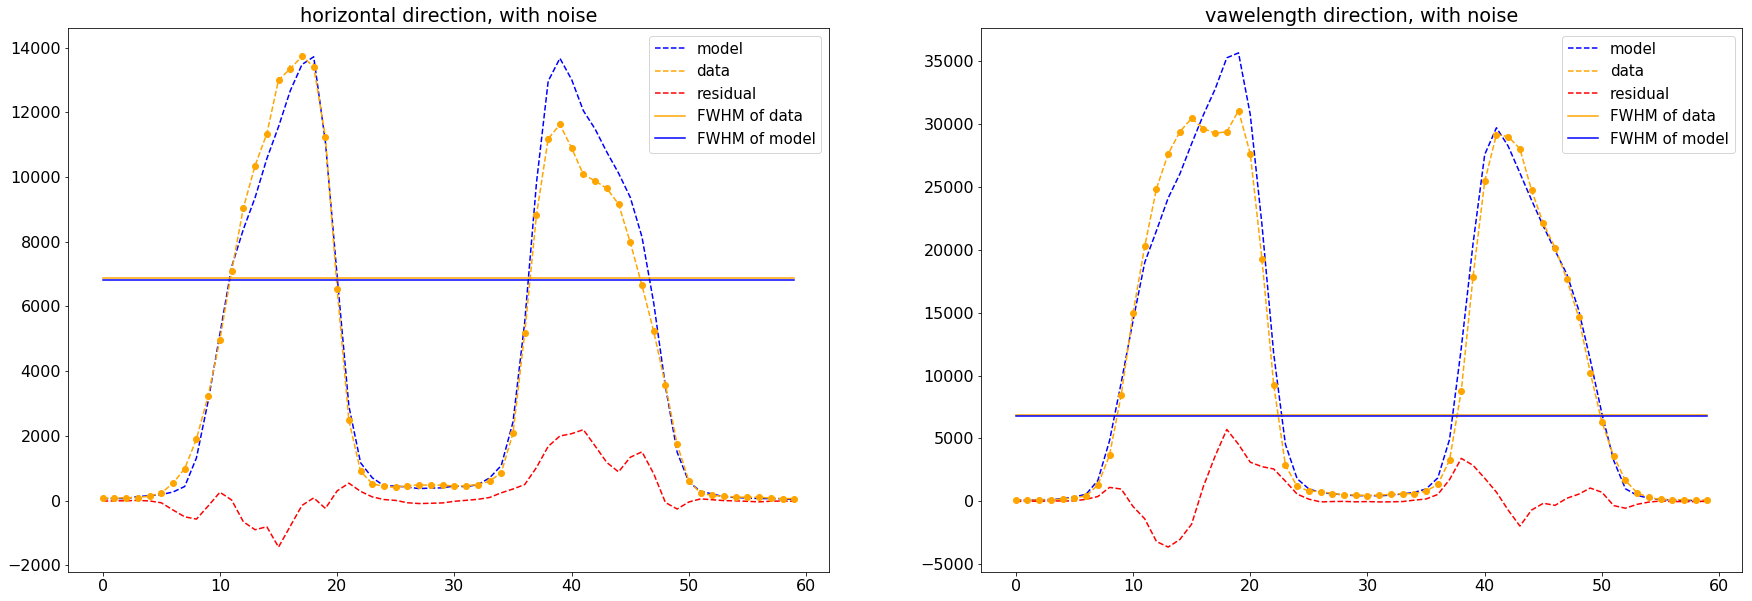

In [980]:
single_analysis.create_cut_plots()

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Sep10/


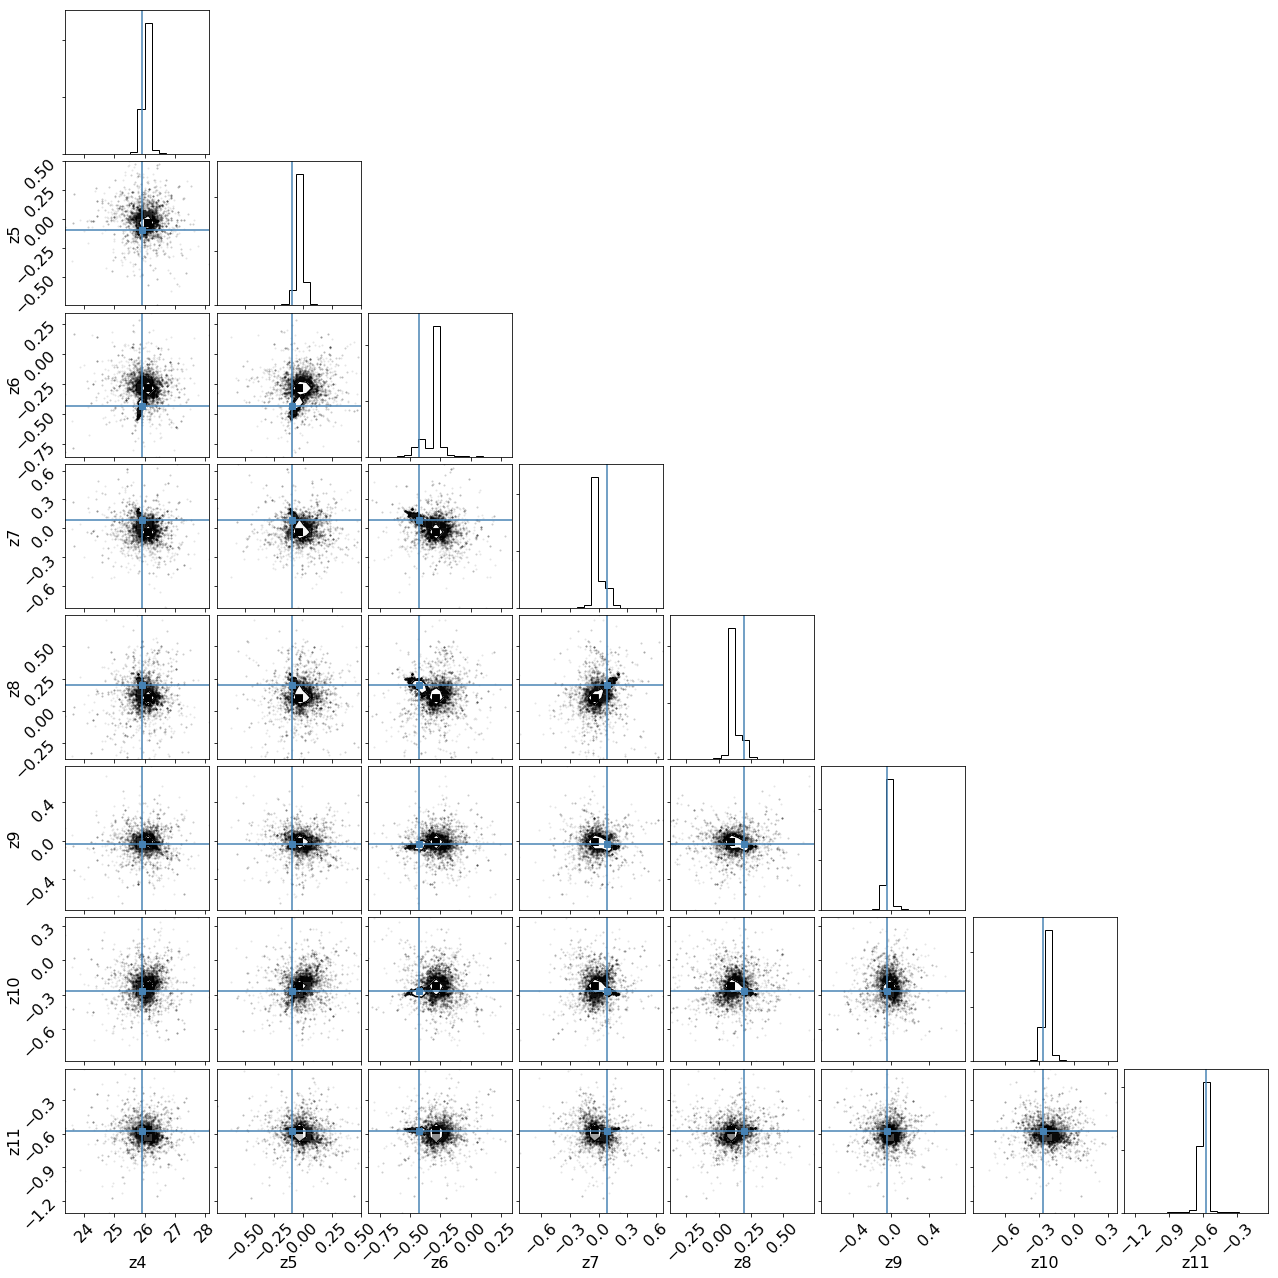

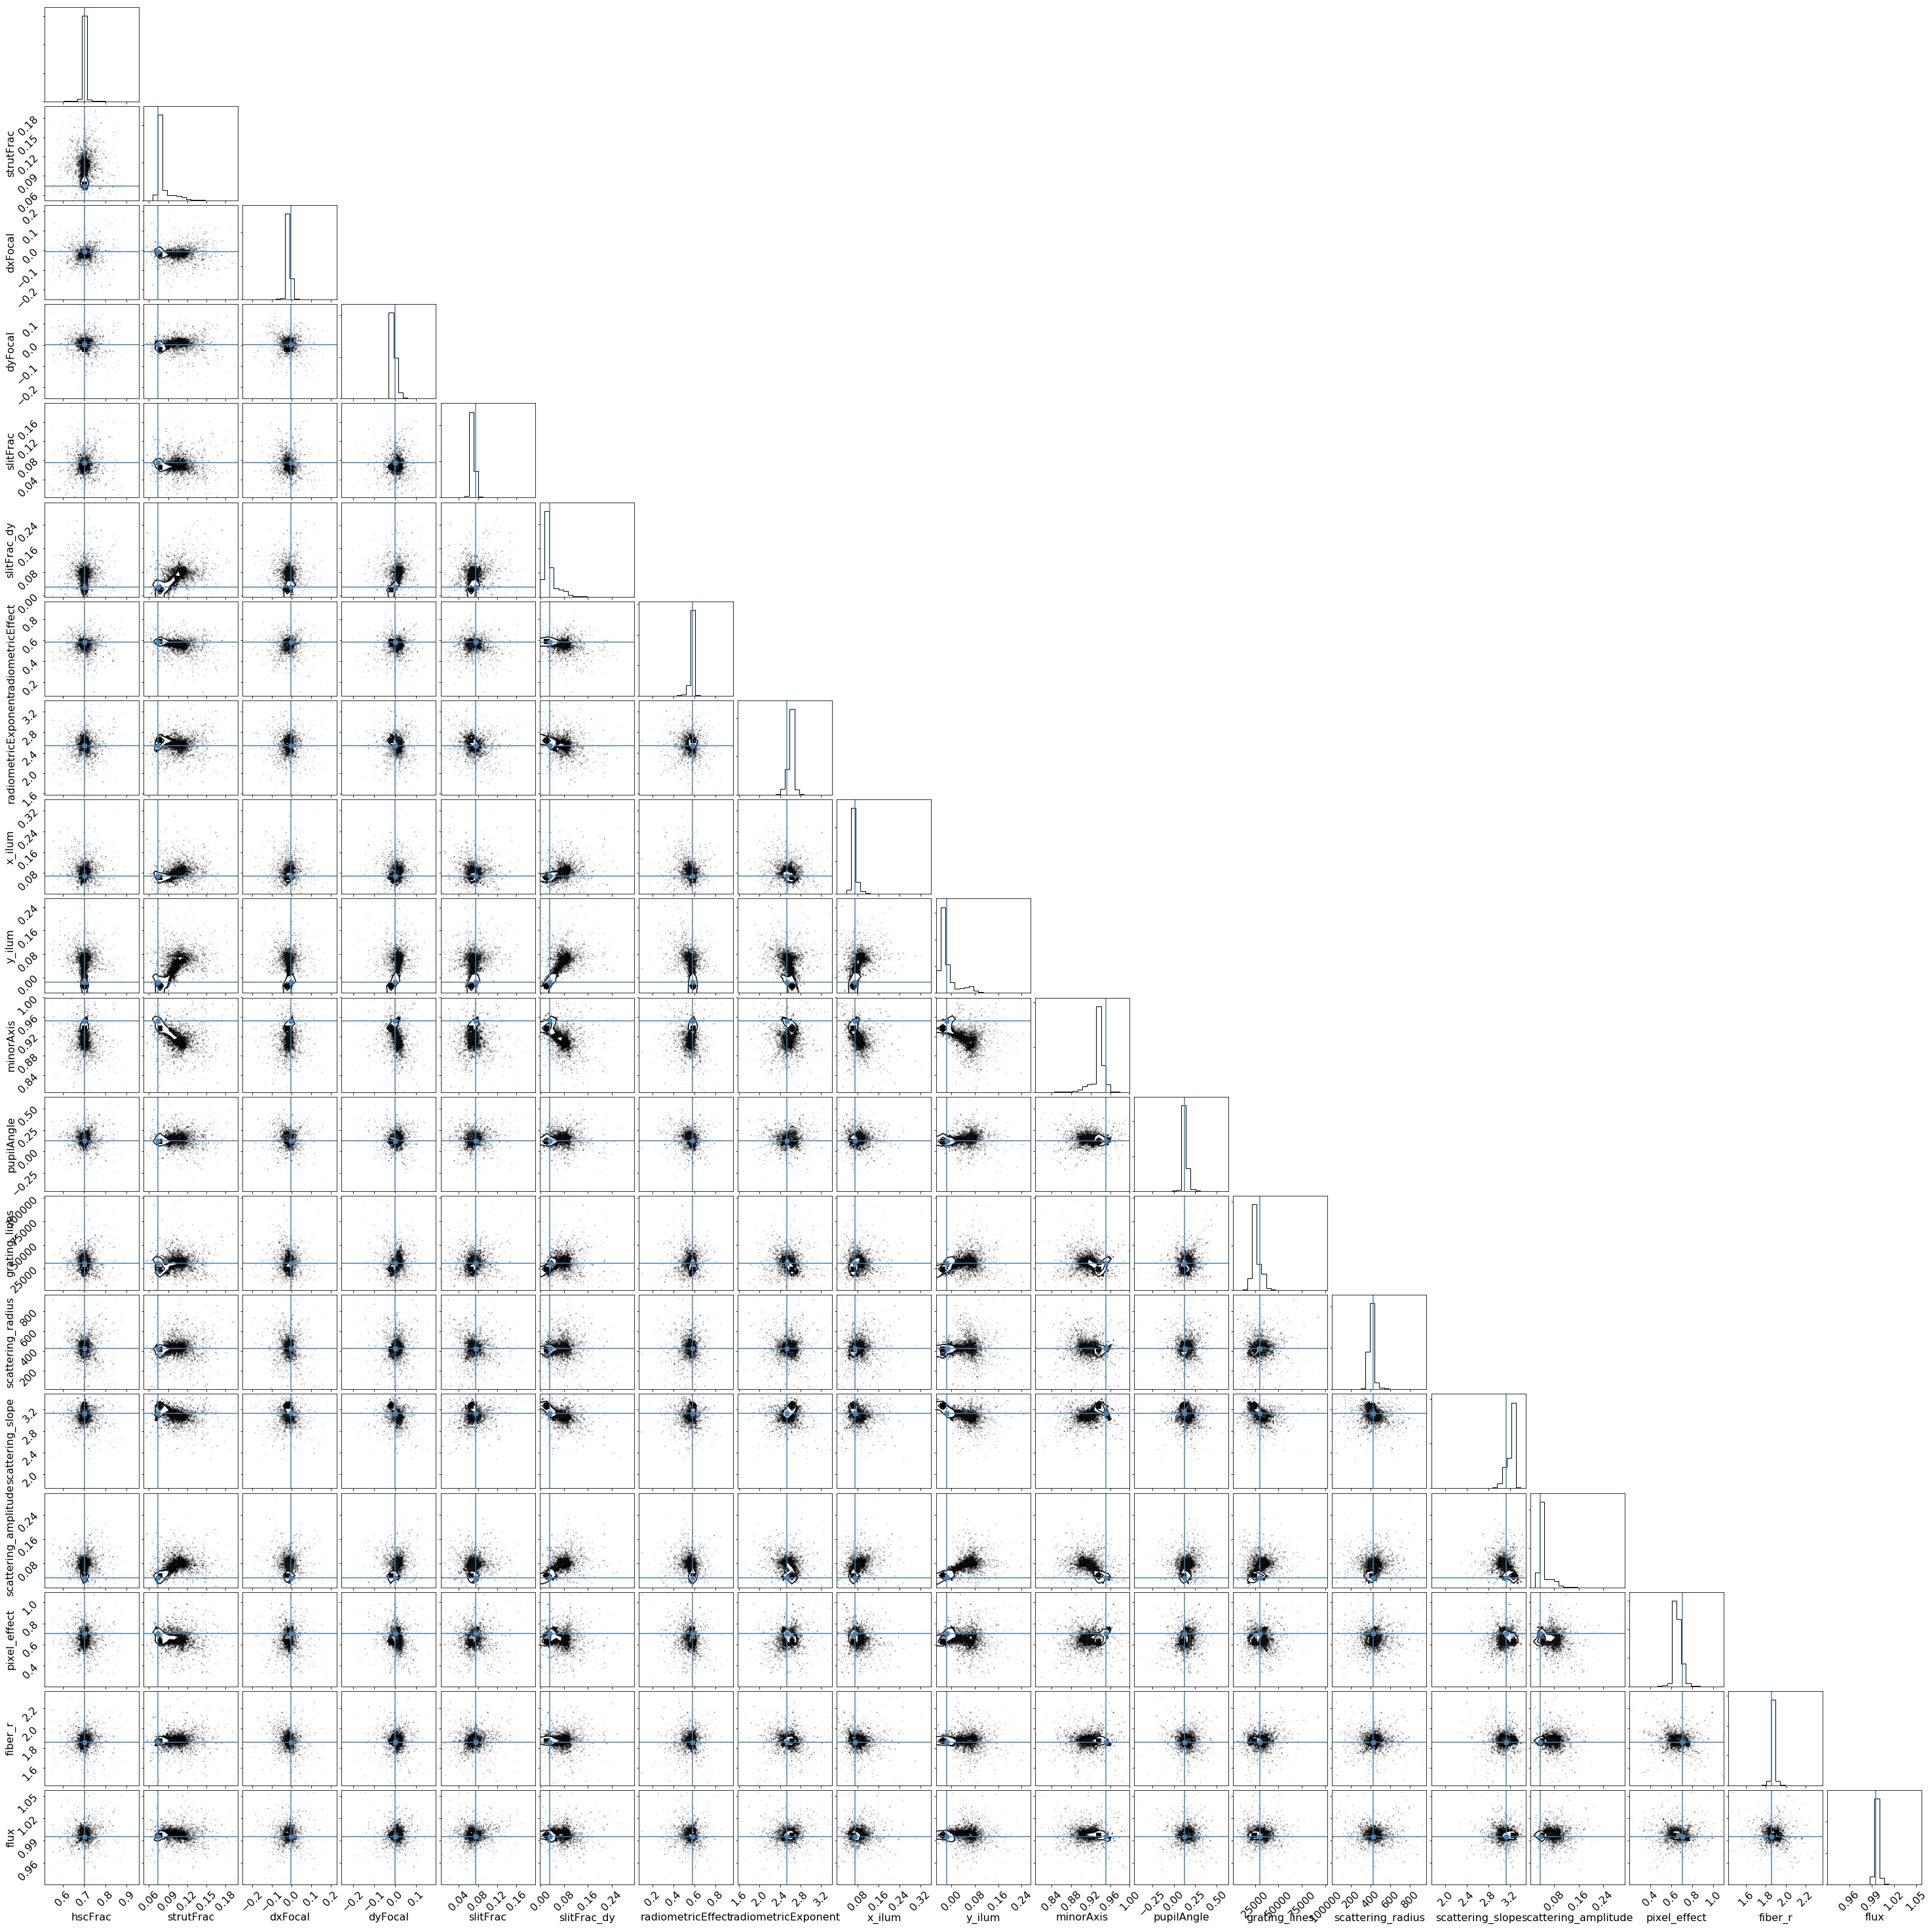

In [80]:
single_analysis.create_corner_plots()

## Prediction

In [991]:
solution_at_0

array([    -0.51939938,     -0.16070373,     -0.2078894 ,      0.24498981,
           -0.07605769,     -0.14634749,     -0.2339859 ,     -0.20790387,
            0.68319113,      0.09860741,      0.01294884,     -0.01798184,
            0.06365397,      0.04610451,      0.51211497,      2.00529714,
            0.14871435,      0.06721893,      0.91825265,     -0.02331616,
            0.90569976,  16360.23799552,    428.77191565,      1.40319841,
            0.01351176,      0.47361772,      1.72035013,      1.00118304,
            2.499022  ,    860.22717285])

In [993]:
minchain=solution_at_0

In [994]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(minchain)-2]]),columns=columns[8:])
print(dfglobal)

         z4        z5        z6       z7        z8        z9       z10  \
0 -0.519399 -0.160704 -0.207889  0.24499 -0.076058 -0.146347 -0.233986   

        z11  
0 -0.207904  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.683191   0.098607  0.012949 -0.017982  0.063654     0.046105   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  minorAxis  \
0           0.512115             2.005297  0.148714  0.067219   0.918253   

   pupilAngle  effective_radius_illumination  grating_lines  \
0   -0.023316                         0.9057   16360.237996   

   scattering_radius  scattering_slope  scattering_amplitude  pixel_effect  \
0         428.771916          1.403198              0.013512      0.473618   

   fiber_r      flux  
0  1.72035  1.001183  


In [995]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   

model(minchain)


-1440.0873062593823

In [996]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

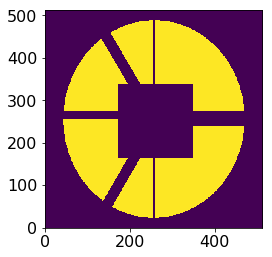

In [997]:
plt.imshow(pupililluminated,origin='lower')

chi**2 reduced is: 7.16476323093
Abs of residual divided by total flux is: 0.0638061234514
Abs of residual divided by largest value of a flux in the image is: 0.0585958664234


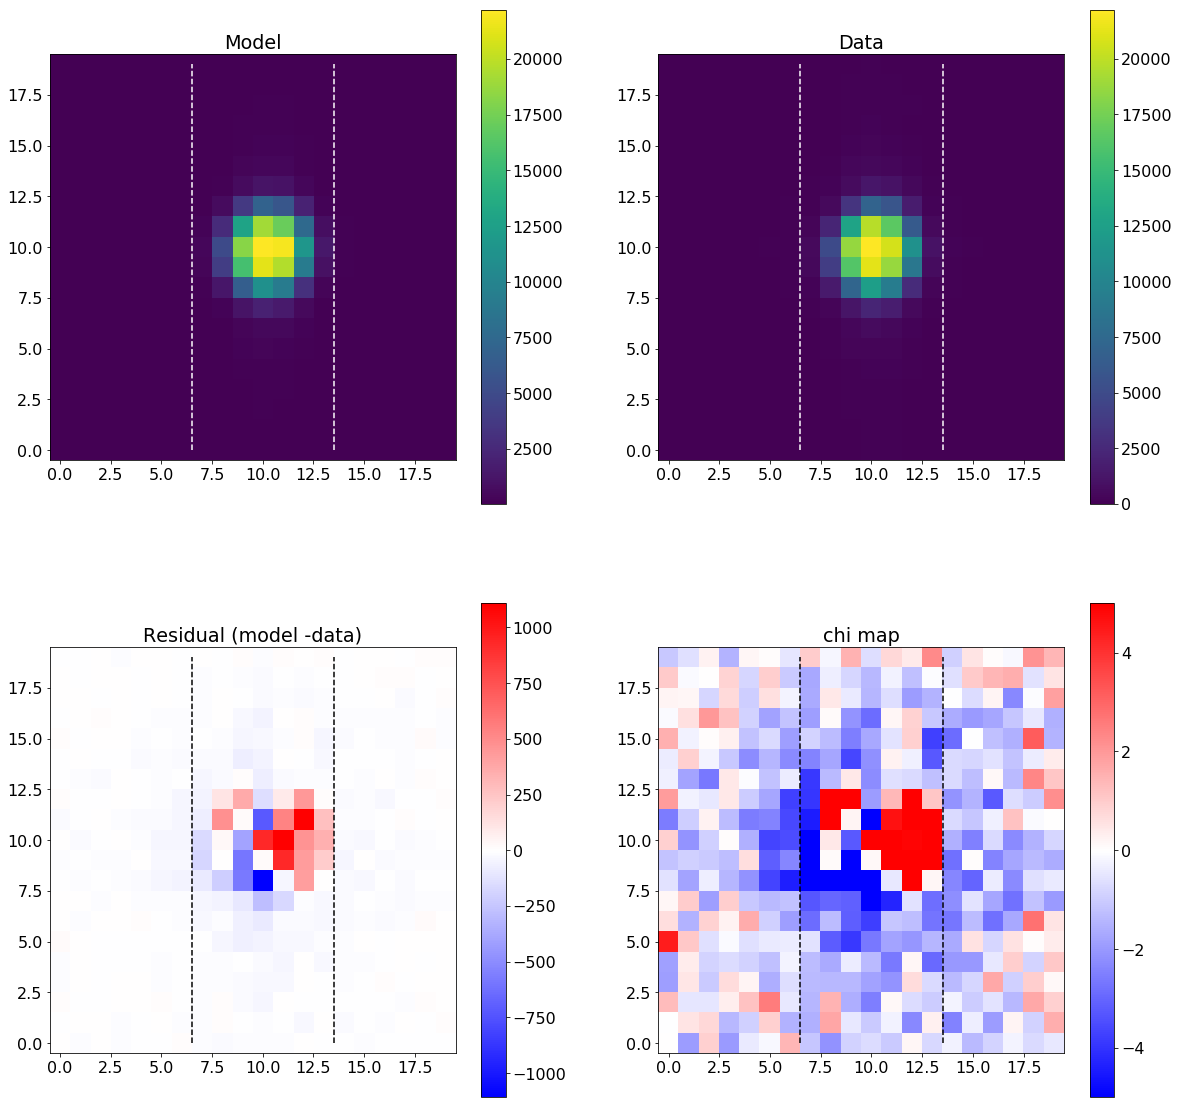

In [998]:
single_analysis.create_basic_comparison_plot()

7.16476323093
chi**2 reduced is: 7.16476323093
Abs of residual divided by total flux is: 0.0638061234514
Abs of residual divided by largest value of a flux in the image is: 0.0585958664234


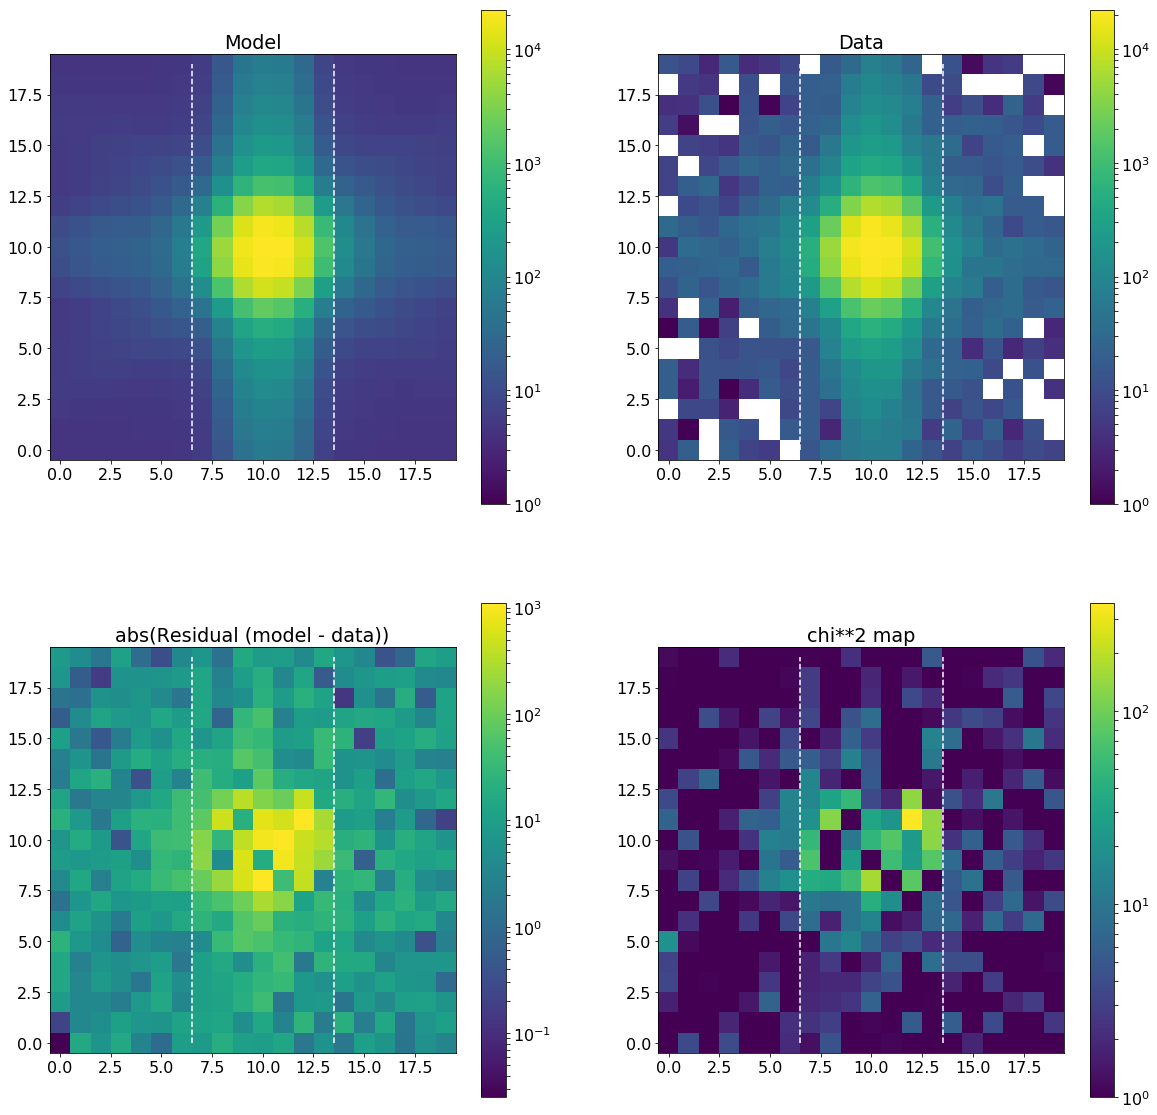

In [999]:
single_analysis.create_basic_comparison_plot_log()

In [895]:
artifical_noise=single_analysis.create_artificial_noise()

7.16476323093


0.063806123451410263

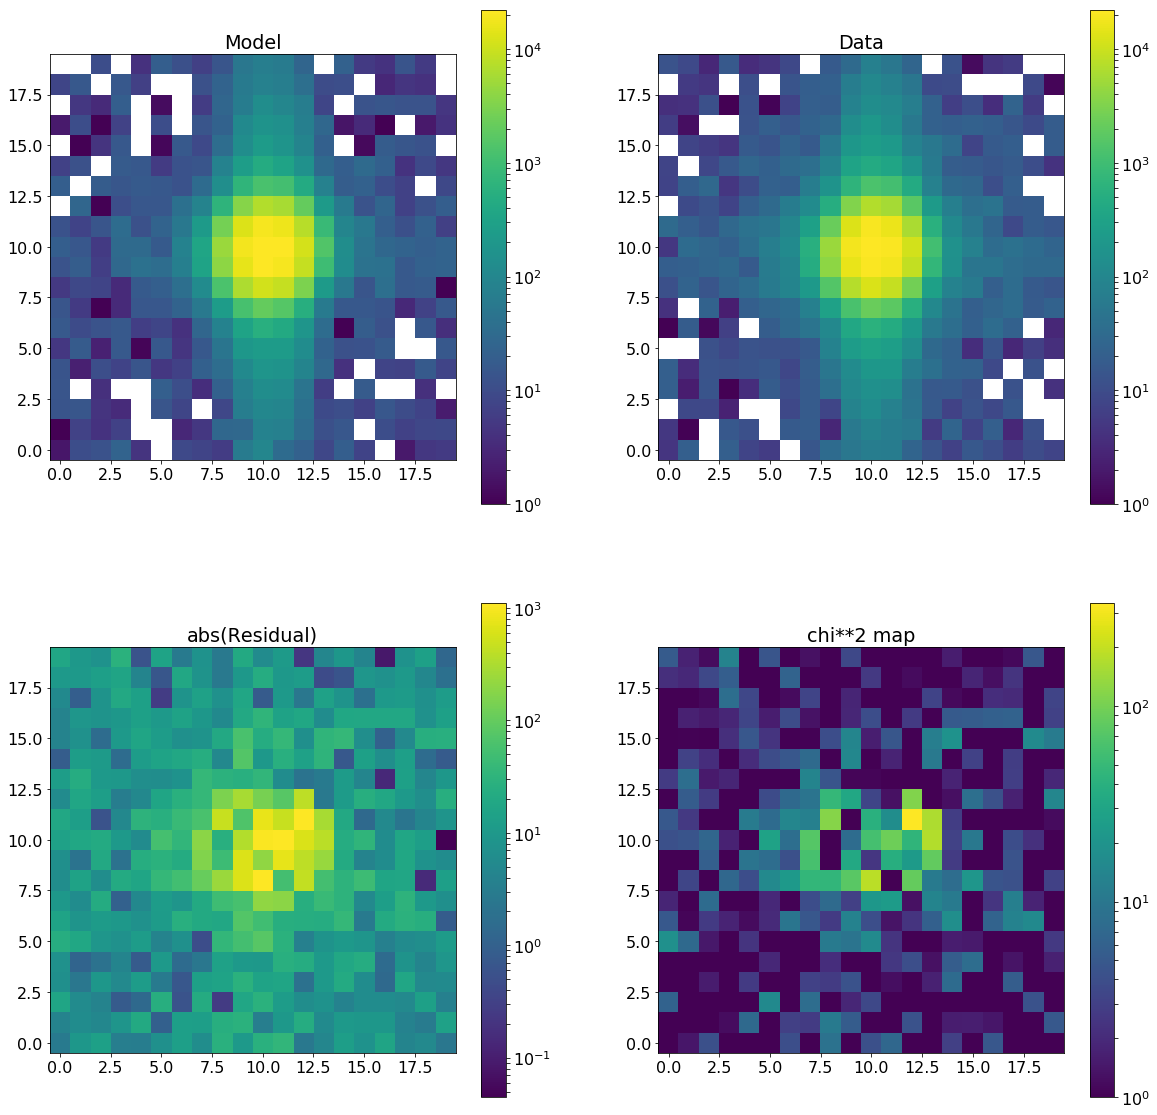

In [896]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

15.5572113585
41.7682722924


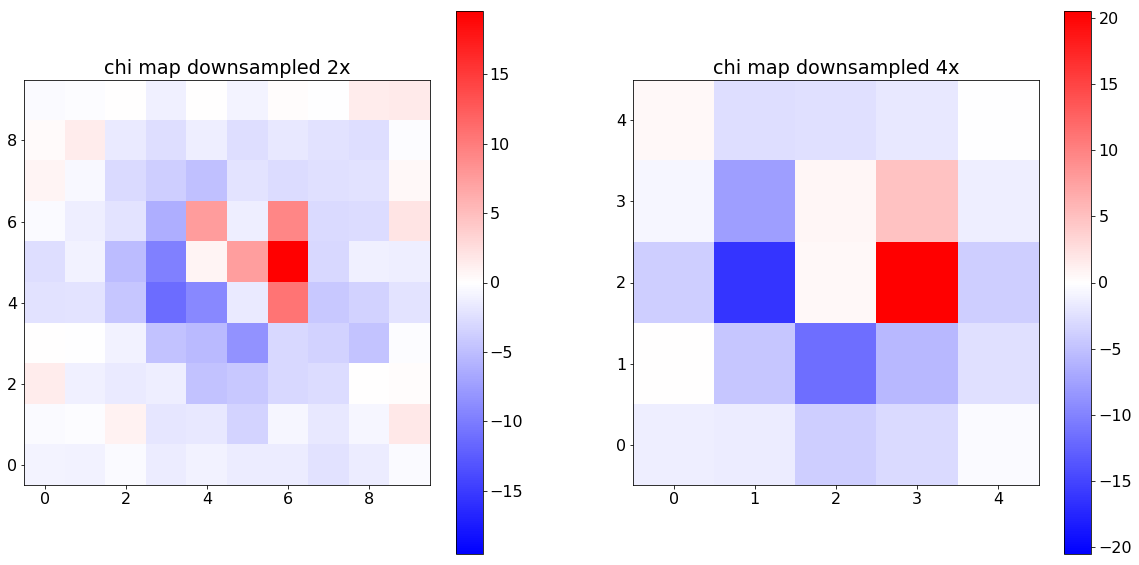

In [898]:
sci_image_2=downsample_manual_function(sci_image,int(sci_image.shape[0]/2))
sci_image_4=downsample_manual_function(sci_image,int(sci_image.shape[0]/4))

res_iapetus_2=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/2))
res_iapetus_4=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/4))

var_image_2=downsample_manual_function(var_image,int(var_image.shape[0]/2))
var_image_4=downsample_manual_function(var_image,int(var_image.shape[0]/4))

chi_downsample_2=(res_iapetus_2-sci_image_2)/np.sqrt(var_image_2)
chi_downsample_4=(res_iapetus_4-sci_image_4)/np.sqrt(var_image_4)

print(np.mean(chi_downsample_2**2))
print(np.mean(chi_downsample_4**2))


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_2,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_2)),vmax=np.max(np.abs(chi_downsample_2)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_4,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_4)),vmax=np.max(np.abs(chi_downsample_4)))
plt.colorbar()
plt.title('chi map downsampled 4x')

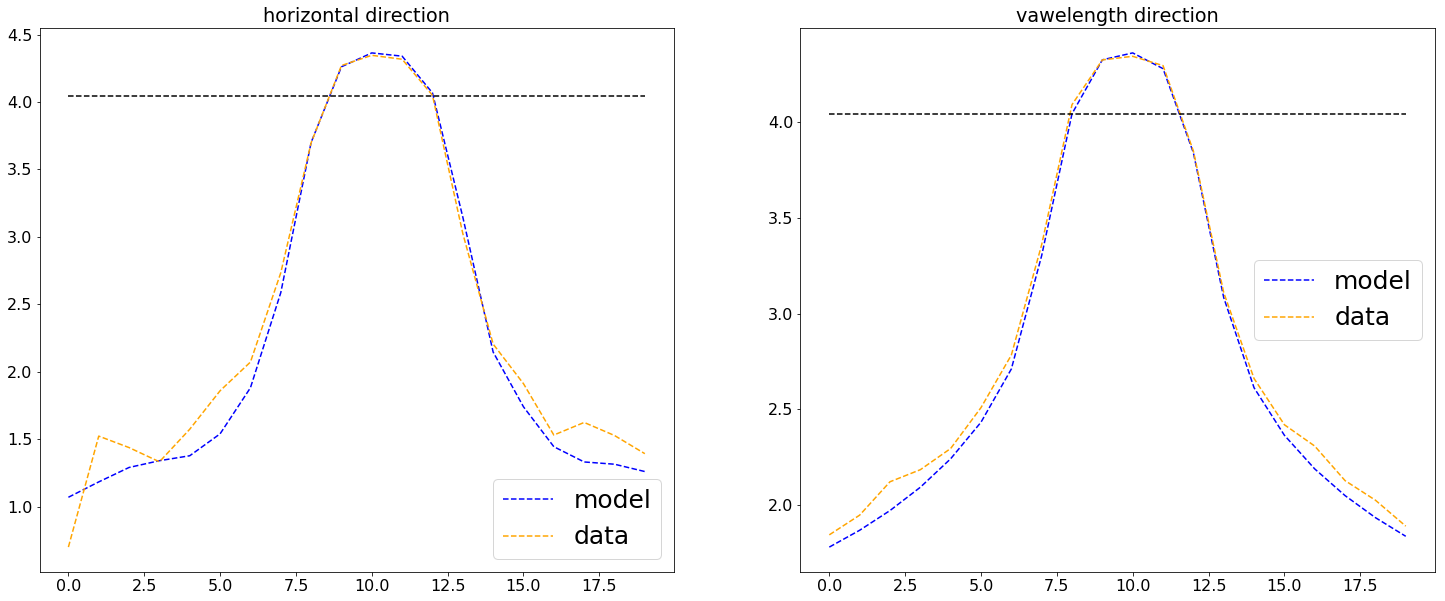

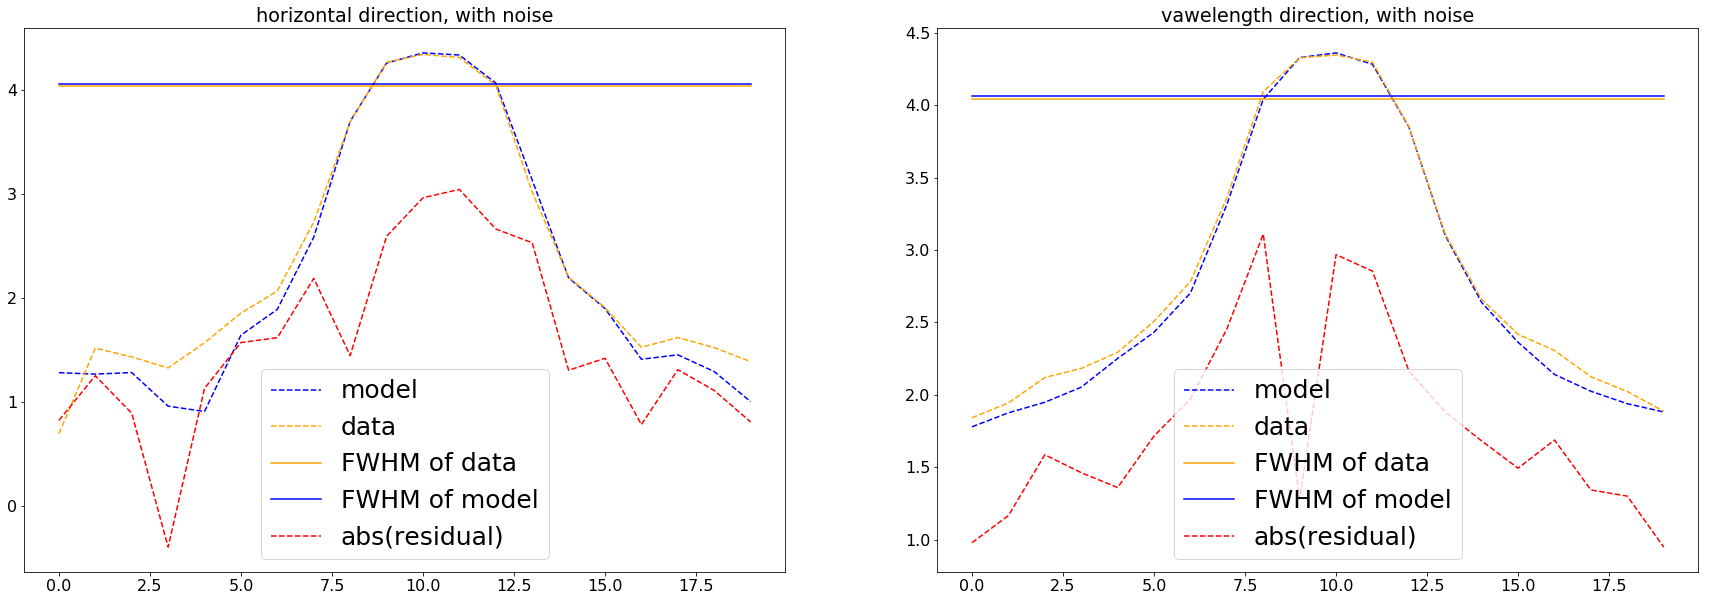

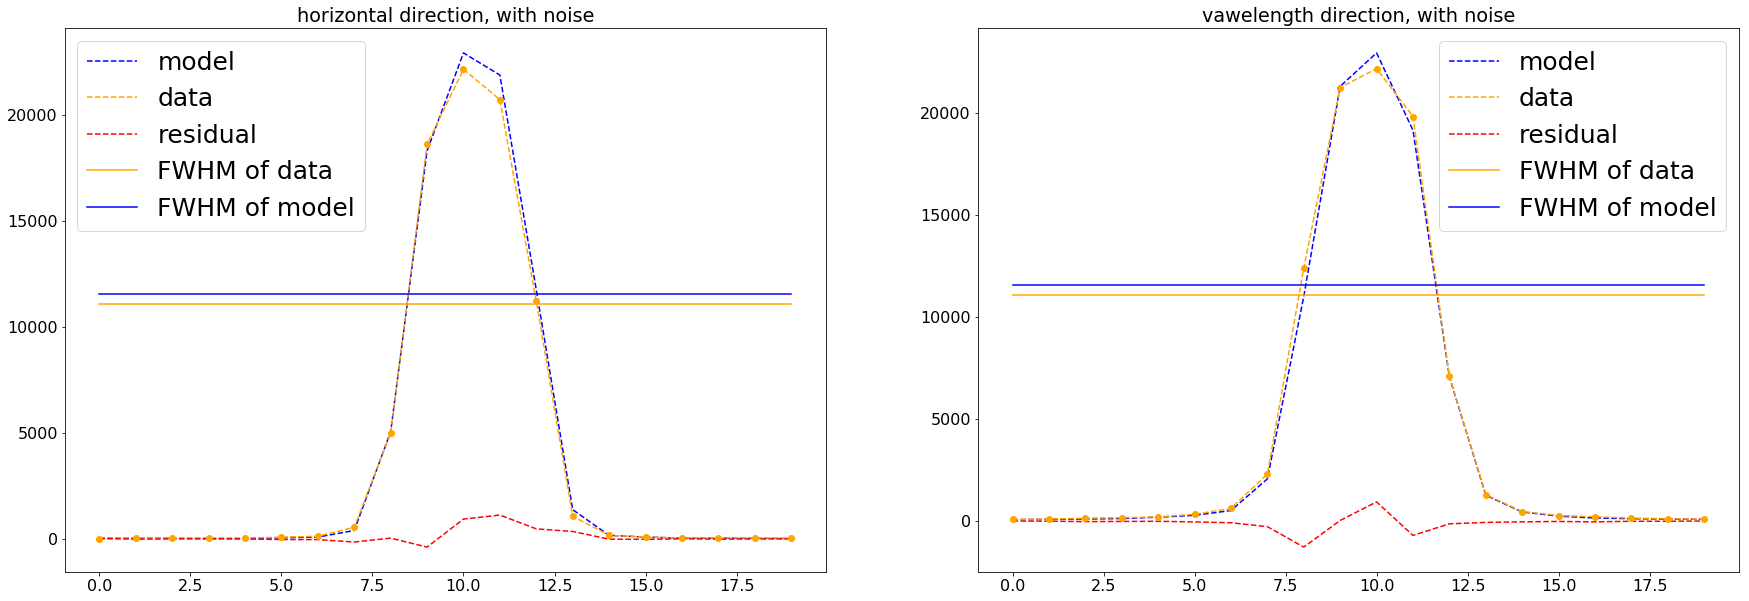

In [899]:
single_analysis.create_cut_plots()

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Sep10/


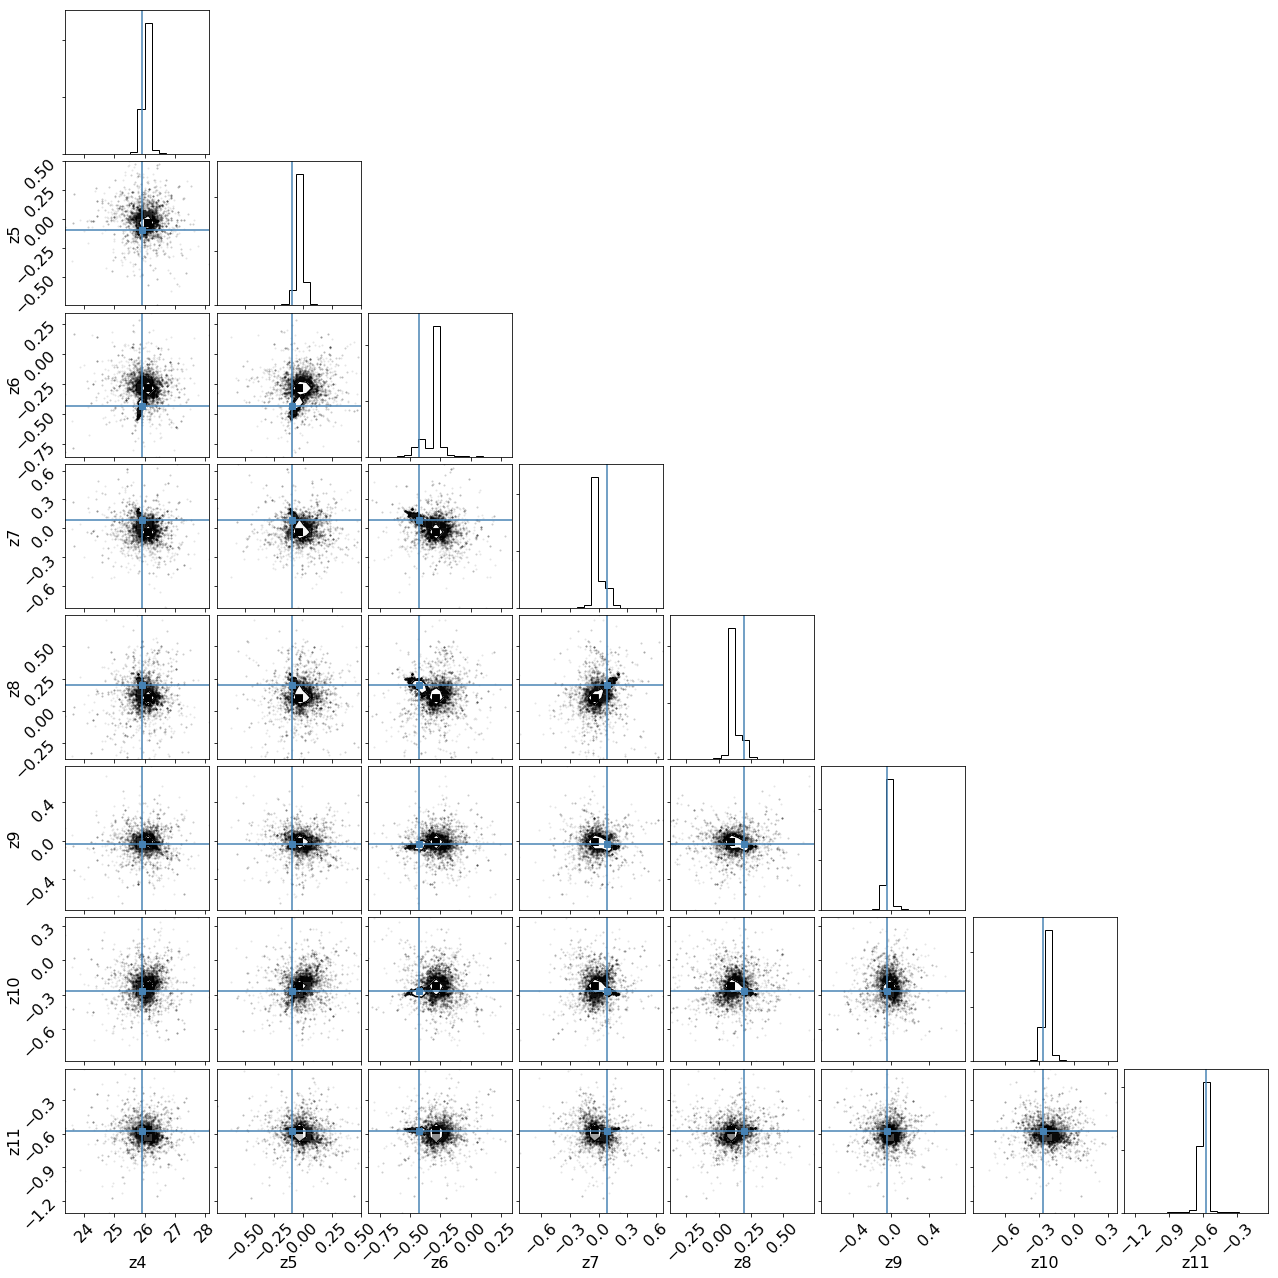

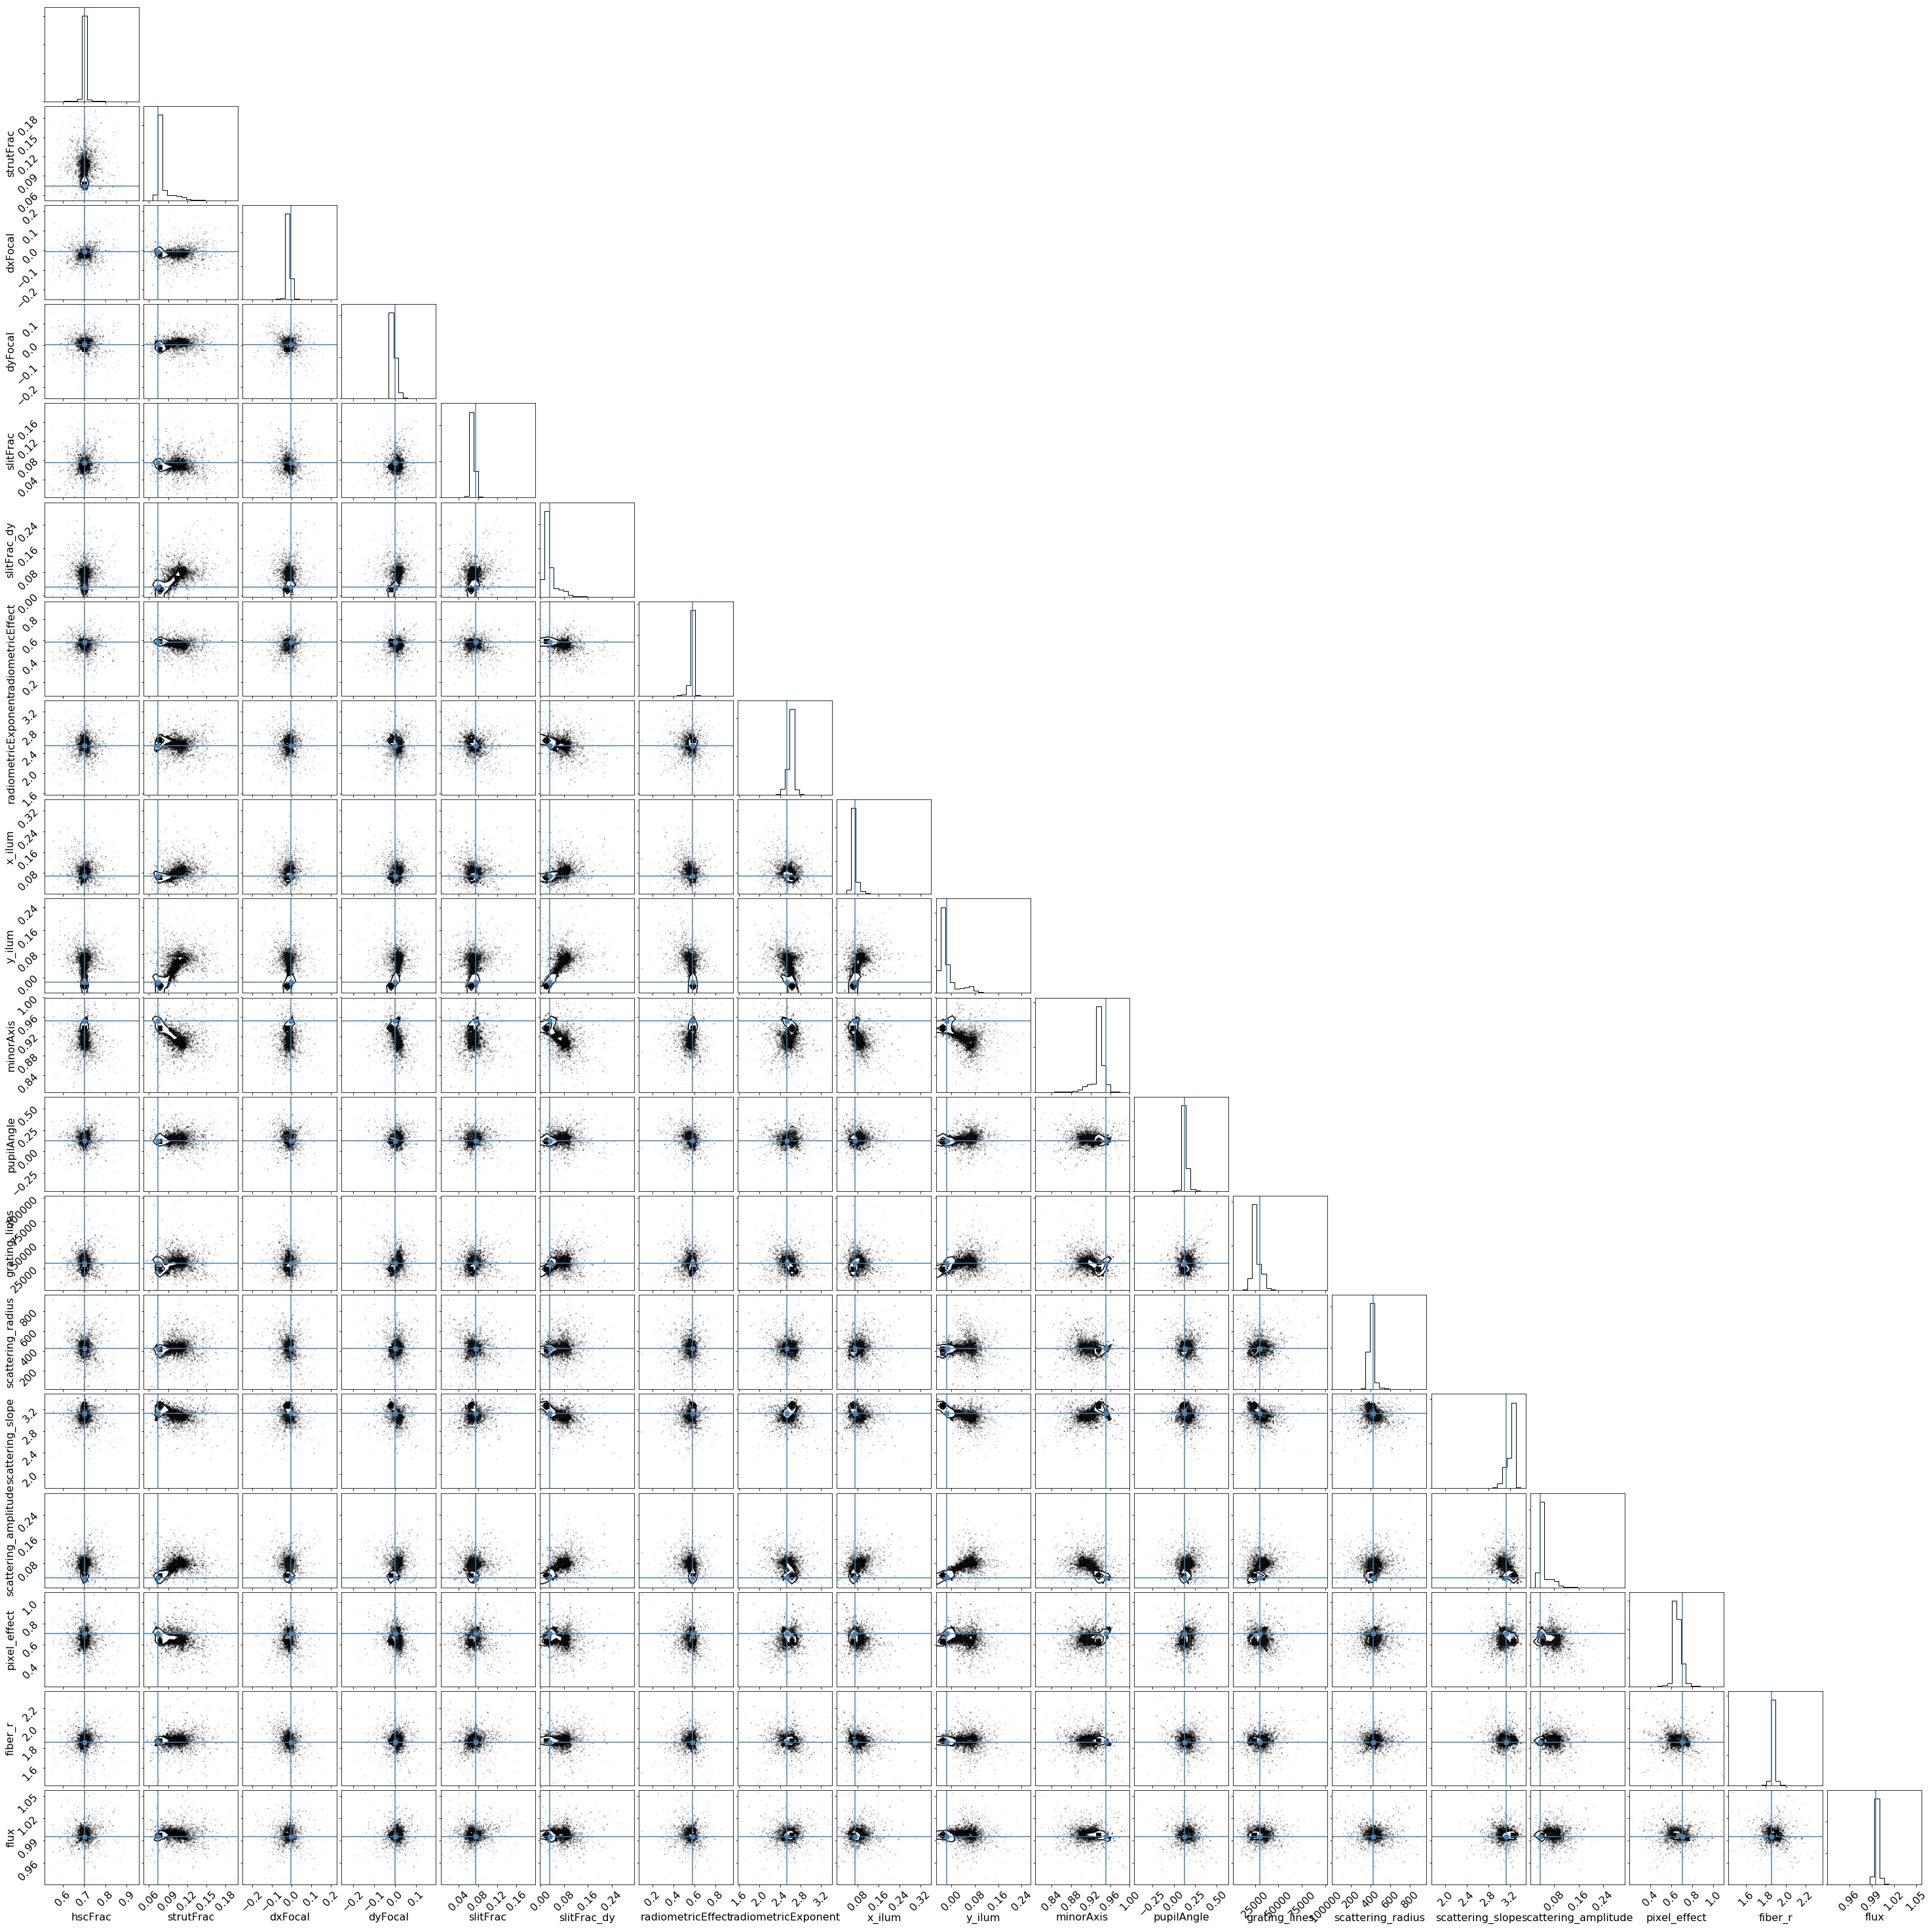

In [80]:
single_analysis.create_corner_plots()